# import modules

In [1]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED
from datetime import datetime, timedelta
from multiprocessing import Process, Pool
import math

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
import pysam
import pyranges
import pybedtools


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import metrics
import scipy
from scipy import io
import scanpy as sc
from sklearn.cluster import KMeans
from adjustText import adjust_text
# import episcanpy
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False
from matplotlib_venn import venn3, venn2, venn3_unweighted, venn2_unweighted

import SCRIP
from SCRIP.utilities import utils
from SCRIP.utilities.utils import print_log, safe_makedirs, read_SingleCellExperiment_rds, excute_info, read_pickle, write_to_mtx, store_to_pickle

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams.update({
    'figure.figsize': [4.0, 4.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'normal',
    'figure.titleweight': 'normal',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [ ]:
plt.rcParams

# Config

In [ ]:
plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'normal',
    'figure.titleweight': 'normal',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

a = yaml.load("""a:\n  b: 2\n  c: 3\n""")

with open('./test.yml', 'w+') as f:
    yaml.dump(a,f)

sc.settings.verbosity = 3
# sc.logging.print_header()
sc.logging.print_versions()


N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [84]:
# pd.set_option('display.max_columns', 500)  
# pd.set_option('display.max_rows', None)  
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)

In [226]:
def umap_table(script_table_cell_tf, metadata):
    sudo_expression_SCRIPT = ad.AnnData(script_table_cell_tf)
#     sc.pp.highly_variable_genes(sudo_expression_SCRIPT)
#     sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack', use_highly_variable=False)
    sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
    sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=50)
    sc.tl.umap(sudo_expression_SCRIPT)
    sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
    sudo_expression_SCRIPT.obs['real_cell_type']=metadata['Celltype'][sudo_expression_SCRIPT.obs.index]
#     sudo_expression_SCRIPT.obs['nFeature_ATAC']=metadata['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]
    sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type'], color_map=regulation_cmp)
    print(sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    print(sklearn.metrics.adjusted_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    return sudo_expression_SCRIPT

In [1554]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
#     pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
#     pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

# PBMC

data downloaded from https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-granulocytes-removed-through-cell-sorting-10-k-1-standard-2-0-0

## load keys

In [12]:
with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/737K-arc-v1_ATAC.txt', 'r') as atac_bc_file:
    atac_bc = [i.rstrip('\n') for i in atac_bc_file.readlines()]

with open('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/737K-arc-v1_RNA.txt', 'r') as rna_bc_file:
    rna_bc = [i.rstrip('\n') for i in rna_bc_file.readlines()]

keys = pd.DataFrame(np.zeros([len(rna_bc),2]), columns=['ATAC','RNA'])

keys['ATAC'] = atac_bc
keys['RNA'] = rna_bc

In [4]:
keys.to_csv('example/PBMC/barcode_key.txt', sep='\t')

In [288]:
marker_dict = {  'B': ['CD79A', 'CD79B', 'CD19', 'MS4A1', 'CR2'],
                 'Plasma': ['SLAMF7', 'IGKC'],
                 'T': ['CD3D', 'CD3G', 'CD3E', 'CD2'], # T
                 'CD8T': ['CD8A', 'CD8B','GZMA','GZMB'], # cd8
                 'CD4T': ['CD4', 'STAT4', 'STAT1'], # cd4
                 'T_Reg': ['FOXP3'], # T reg
                 'T_Exhausted': ['LAG3', 'PDCD1', 'CTLA4', 'HAVCR2'], # T exhau
#                  'T_MKI67': ['MKI67', 'TOP2A'], # T MKI67
                 'NK': ['KLRC1', 'KLRD1', 'KIR2DL4'], #NK
                 'Mono': ['CD68', 'CSF1R', 'ADGRE1', 'ACE'],
                 'CD14Mono': ['CD14'], #mono
                 'CD16Mono': ['FCGR3A', 'TEK', 'SELL'], #mono
                 'Macrophages': ['FCGR2A', 'CSF1R', 'CD163', 'CD68', 'MRC1', 'MSR1'], #macro
                 'DC': ['CD86', 'ITGAX', 'FLT3', 'GZMB', 'IL3RA'], #dc
                 'pDC': ['CLEC4C'], # pdc
                 'Endothelial': ['PECAM1', 'NKAIN2'],  # endothelial
                 'Neutrophils': ['S100A9', 'CSF1R'], # neutrophils
#                  'Platelet':['PRTN3'],
                'Others':['BCL11A', 'BCL11B']
                }

marker_list = []
for i in marker_dict:
    marker_list = marker_list + marker_dict[i]

In [691]:
tmp = sc.read_h5ad('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613/H3K27ac/imputed_H3K27ac.h5ad')

In [693]:
write_to_mtx(tmp, '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/histone/peak_base/cuttagpro/SCRIP_PBMC/imputationPBMC0613/H3K27ac/imputed_H3K27ac_mtx')

## RNA-seq analysis

In [682]:
rna_adata = sc.read_10x_h5('example/PBMC/data/pbmc_granulocyte_sorted_10k_raw_feature_bc_matrix.h5')
rna_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [683]:
rna_adata.obs.index = [i.split('-')[0] for i in rna_adata.obs.index]

In [684]:
sc.pp.filter_cells(rna_adata, min_genes=500)
sc.pp.filter_genes(rna_adata, min_cells=5)

In [685]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


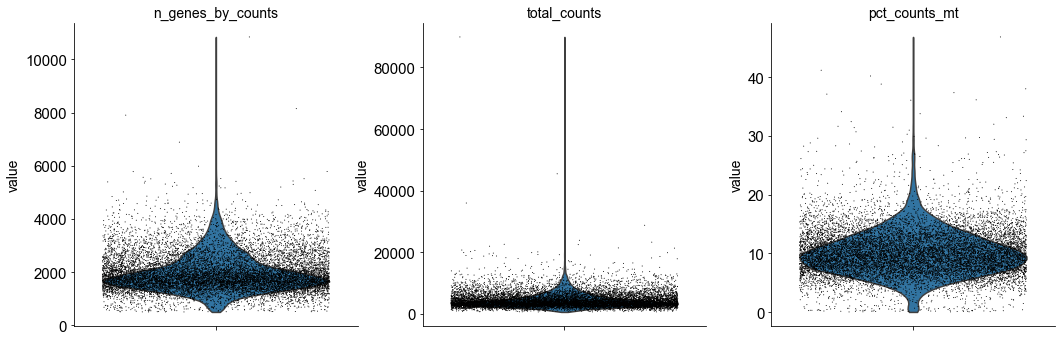

In [686]:
sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

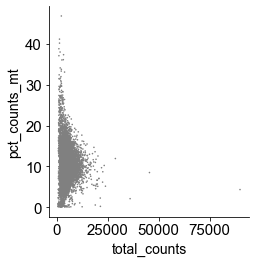

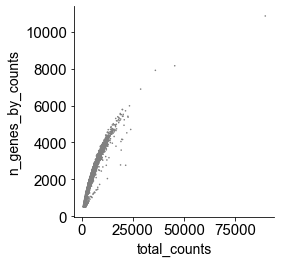

In [687]:
sc.pl.scatter(rna_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(rna_adata, x='total_counts', y='n_genes_by_counts')

In [688]:
rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 6000, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

View of AnnData object with n_obs × n_vars = 11817 × 24644
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/scanpy-1.8.1-py3.8.egg/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


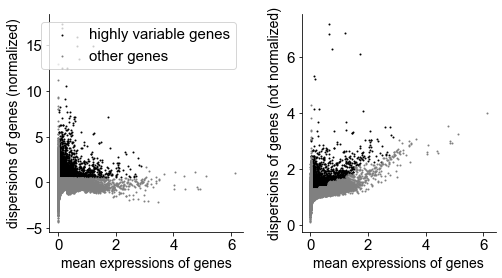

In [297]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(rna_adata)

In [299]:
rna_adata.raw = rna_adata

In [ ]:
sc.pp.regress_out(rna_adata, ['total_counts'])

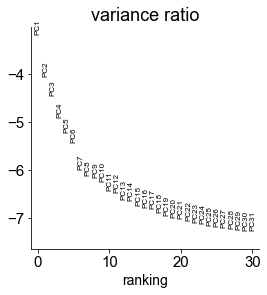

In [323]:
sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_adata, log=True)
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna_adata)

In [ ]:
sc.tl.louvain(rna_adata)
sc.tl.rank_genes_groups(rna_adata, 'louvain', method='wilcoxon')

### louvain annotation

In [340]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(rna_adata, color=['louvain'], legend_loc='on data', title='PBMC RNA Cluster', legend_fontsize=15, ax=ax)
# fig.savefig(fname='Figures/PBMC_RNA_cluster_louvain.pdf', format='pdf')

categories: 0, 1, 2, etc.
var_group_labels: B, Plasma, T, etc.


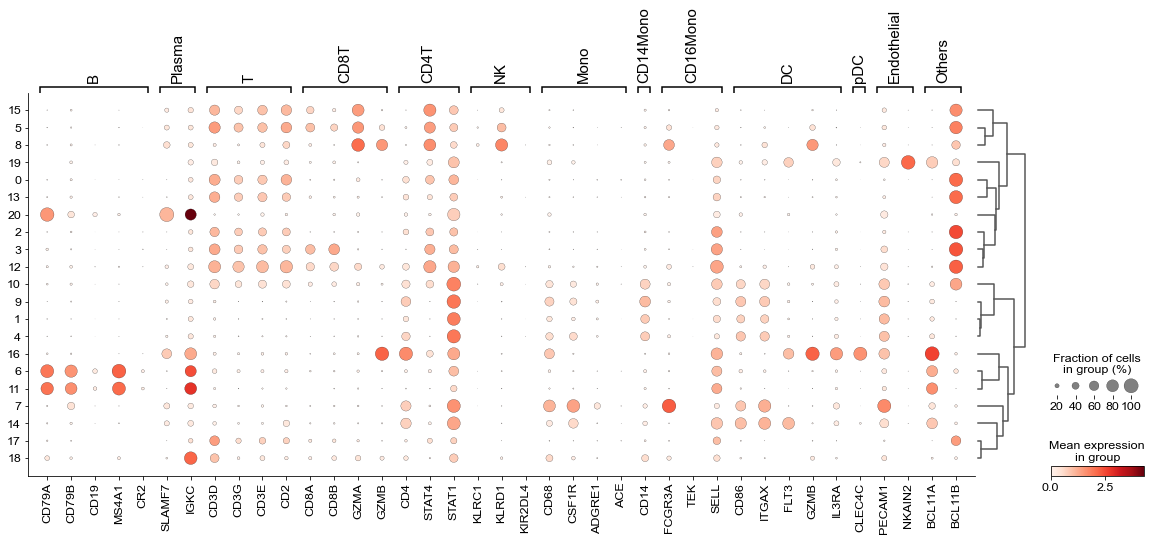

In [383]:
marker_dict = {  'B': ['CD79A', 'CD79B', 'CD19', 'MS4A1', 'CR2'],
                 'Plasma': ['SLAMF7', 'IGKC'],
                 'T': ['CD3D', 'CD3G', 'CD3E', 'CD2'], # T
                 'CD8T': ['CD8A', 'CD8B','GZMA','GZMB'], # cd8
                 'CD4T': ['CD4', 'STAT4', 'STAT1'], # cd4
#                  'T_Reg': ['FOXP3'], # T reg
#                  'T_Exhausted': ['LAG3', 'PDCD1', 'CTLA4', 'HAVCR2'], # T exhau
#                  'T_MKI67': ['MKI67', 'TOP2A'], # T MKI67
                 'NK': ['KLRC1', 'KLRD1', 'KIR2DL4'], #NK
                 'Mono': ['CD68', 'CSF1R', 'ADGRE1', 'ACE'],
                 'CD14Mono': ['CD14'], #mono
                 'CD16Mono': ['FCGR3A', 'TEK', 'SELL'], #mono
#                  'Macrophages': ['FCGR2A', 'CSF1R', 'CD163', 'CD68', 'MRC1', 'MSR1'], #macro
                 'DC': ['CD86', 'ITGAX', 'FLT3', 'GZMB', 'IL3RA'], #dc
                 'pDC': ['CLEC4C'], # pdc
                 'Endothelial': ['PECAM1', 'NKAIN2'],  # endothelial
#                  'Neutrophils': ['S100A9', 'CSF1R'], # neutrophils
#                  'Platelet':['PRTN3'],
                'Others':['BCL11A', 'BCL11B']
                }


fig, ax = plt.subplots(1,1,figsize=(20,8))
sc.pl.dotplot(rna_adata,marker_dict, 'louvain', dendrogram=True, ax=ax)
fig.savefig(fname='Figures/PBMC_RNA_Marker_louvain.pdf', format='pdf')

In [671]:
remove_cell_index = rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [10, 14, 18]])].index
keep_cell_index = list(set(rna_adata.obs_names) - set(remove_cell_index))

In [ ]:
rna_adata = sc.read_10x_h5('example/PBMC/data/pbmc_granulocyte_sorted_10k_raw_feature_bc_matrix.h5')
rna_adata.var_names_make_unique()
rna_adata.obs.index = [i.split('-')[0] for i in rna_adata.obs.index]

sc.pp.filter_cells(rna_adata, min_genes=500)
sc.pp.filter_genes(rna_adata, min_cells=5)

rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

rna_adata = rna_adata[rna_adata.obs.n_genes_by_counts < 6000, :]
rna_adata = rna_adata[rna_adata.obs.pct_counts_mt < 20, :]

rna_adata = rna_adata[keep_cell_index,:]

sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

rna_adata.raw = rna_adata

sc.pp.regress_out(rna_adata, ['total_counts'])

sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna_adata)

In [690]:
sc.tl.louvain(rna_adata)
sc.tl.rank_genes_groups(rna_adata, 'louvain', method='wilcoxon')

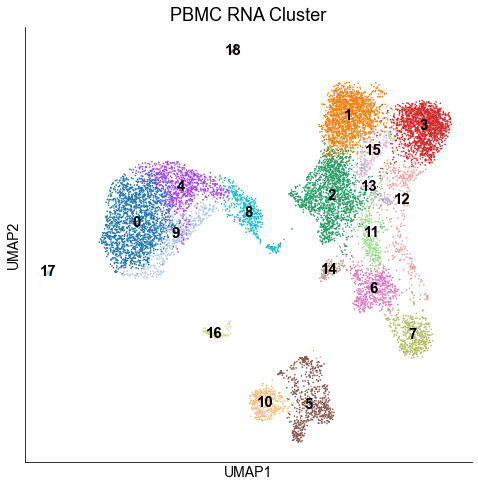

In [791]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(rna_adata, color=['louvain'], legend_loc='on data', title='PBMC RNA Cluster', legend_fontsize=15, ax=ax)
fig.savefig(fname='Figures/PBMC_RNA_cluster_louvain.pdf', format='pdf')

categories: 0, 1, 2, etc.
var_group_labels: B, Plasma, T, etc.


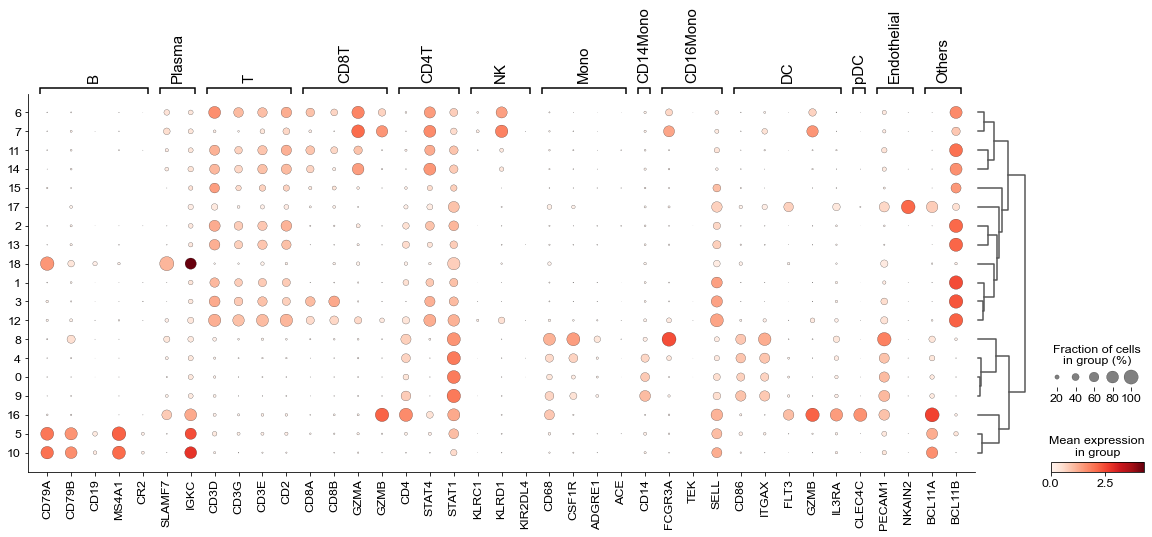

In [692]:
marker_dict = {  'B': ['CD79A', 'CD79B', 'CD19', 'MS4A1', 'CR2'],
                 'Plasma': ['SLAMF7', 'IGKC'],
                 'T': ['CD3D', 'CD3G', 'CD3E', 'CD2'], # T
                 'CD8T': ['CD8A', 'CD8B','GZMA','GZMB'], # cd8
                 'CD4T': ['CD4', 'STAT4', 'STAT1'], # cd4
#                  'T_Reg': ['FOXP3'], # T reg
#                  'T_Exhausted': ['LAG3', 'PDCD1', 'CTLA4', 'HAVCR2'], # T exhau
#                  'T_MKI67': ['MKI67', 'TOP2A'], # T MKI67
                 'NK': ['KLRC1', 'KLRD1'], #NK
                 'Mono': ['CD68', 'CSF1R', 'ADGRE1'],
                 'CD14Mono': ['CD14'], #mono
                 'CD16Mono': ['FCGR3A', 'TEK', 'SELL'], #mono
#                  'Macrophages': ['FCGR2A', 'CSF1R', 'CD163', 'CD68', 'MRC1', 'MSR1'], #macro
                 'DC': ['CD86', 'ITGAX', 'FLT3', 'GZMB', 'IL3RA'], #dc
                 'pDC': ['CLEC4C'], # pdc
                 'Endothelial': ['PECAM1', 'NKAIN2'],  # endothelial
#                  'Neutrophils': ['S100A9', 'CSF1R'], # neutrophils
#                  'Platelet':['PRTN3'],
                'Others':['BCL11A', 'BCL11B']
                }


fig, ax = plt.subplots(1,1,figsize=(20,8))
sc.pl.dotplot(rna_adata,marker_dict, 'louvain', dendrogram=True, ax=ax)
# fig.savefig(fname='Figures/PBMC_RNA_Marker_louvain.pdf', format='pdf')

In [697]:
rna_adata.obs['louvain_cell_type'] = rna_adata.obs['louvain'].astype("str")

rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [11,14,3,12]])].index, 'louvain_cell_type'] = 'CD8T'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [1,2,13,15]])].index, 'louvain_cell_type'] = 'CD4T'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [6,7]])].index, 'louvain_cell_type'] = 'NK'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [5,10]])].index, 'louvain_cell_type'] = 'B'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [18]])].index, 'louvain_cell_type'] = 'Plasma'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [4,0,9]])].index, 'louvain_cell_type'] = 'CD14Mono'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [8]])].index, 'louvain_cell_type'] = 'CD16Mono'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [16]])].index, 'louvain_cell_type'] = 'pDC'
rna_adata.obs.loc[rna_adata.obs[rna_adata.obs['louvain'].isin([str(i) for i in [17]])].index, 'louvain_cell_type'] = 'Endothelial'

rna_adata.obs['louvain_cell_type'] = rna_adata.obs['louvain_cell_type'].astype("category")

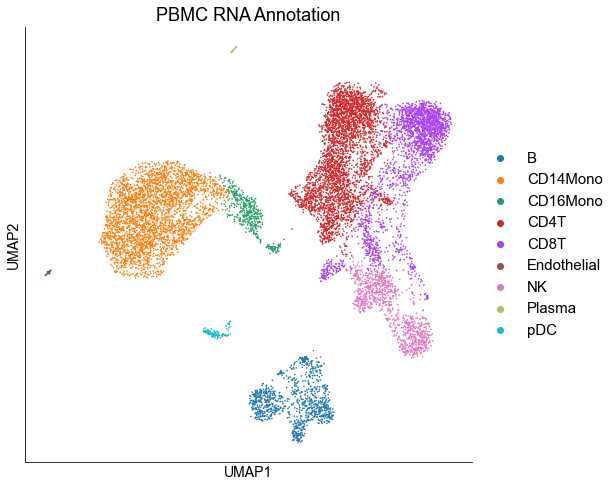

In [793]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(rna_adata, color=['louvain_cell_type'], title='PBMC RNA Annotation', legend_fontsize=15,ax=ax)
fig.savefig(fname='Figures/PBMC_RNA_annotation_louvain.pdf', format='pdf')

In [700]:
rna_adata.write_h5ad('example/PBMC/data/PBMC_granulocyte_sorted_10k_scanpy_reannotate.h5ad')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


In [9]:
rna_adata = ad.read_h5ad('example/PBMC/data/PBMC_granulocyte_sorted_10k_scanpy_reannotate.h5ad')

In [ ]:
mean_expr_dict = {}
for i in rna_adata.obs['louvain_cell_type'].unique():
#     rna_adata[rna_adata.obs.index[rna_adata.obs['louvain_cell_type'] == i],:].to_df().mean()
    mean_expr_dict[i] = rna_adata.raw.to_adata()[rna_adata.obs.index[rna_adata.obs['louvain_cell_type'] == i],:].to_df().mean()

In [701]:
mean_expr_dict_df = pd.DataFrame(mean_expr_dict)

In [702]:
mean_expr_dict_df.to_csv('example/PBMC/cluster_expr.txt', sep='\t')

## ATAC_filter

In [706]:
atac_adata = sc.read_10x_h5('example/PBMC/data/PBMC_granulocyte_sorted_10k_peak_count.h5', gex_only=False)

In [707]:
keys.index = keys['RNA']

In [708]:
atac_index = list(set(atac_adata.obs.index).intersection(set(keys.loc[rna_adata.obs.index,'ATAC'])))

In [709]:
atac_adata = atac_adata[atac_index,:]

In [710]:
destination = 'example/PBMC/data/ATAC/filtered_mtx'
pd.DataFrame(atac_adata.var.index).to_csv(os.path.join(destination, "features.tsv" ),   sep = "\t", index = False, header=False)
pd.DataFrame(atac_adata.obs.index).to_csv(os.path.join(destination, "barcodes.tsv"), sep = "\t", index = False, header=False)
io.mmwrite(os.path.join(destination, "matrix.mtx"), atac_adata.X.T)

In [711]:
atac_peakcount = sc.read_10x_h5('example/PBMC/data/ATAC/filtered_mtx/PBMC_granulocyte_sorted_10k_filtered_peak_count.h5', gex_only=False)

## ATAC reannotate

In [795]:
atac_adata = read_SingleCellExperiment_rds('example/PBMC/pbmc_ATAC_singlecellexperiment.rds')

In [796]:
atac_adata.obs['Celltype'] = atac_adata.obs['seurat_clusters'].astype('str')
keys.index = keys['ATAC']
for i in atac_adata.obs.index:
    rna_bc = keys.loc[i,'RNA']
    try:
        atac_adata.obs.loc[i, 'Celltype'] = str(rna_adata.obs.loc[rna_bc,'louvain_cell_type'])
    except:
        atac_adata.obs.loc[i, 'Celltype'] = 'N'
atac_adata.obs['Celltype'] = atac_adata.obs['Celltype'].astype("category")

In [797]:
atac_adata.obs['Celltype'].unique()

['CD8T', 'CD14Mono', 'CD4T', 'CD16Mono', 'B', 'NK', 'Endothelial', 'pDC', 'Plasma']
Categories (9, object): ['B', 'CD14Mono', 'CD16Mono', 'CD4T', ..., 'Endothelial', 'NK', 'Plasma', 'pDC']

In [798]:
atac_adata.obs['seurat_clusters'] = atac_adata.obs['seurat_clusters'].astype('category')
atac_adata.obs['nFeature_ATAC'] = atac_adata.obs['nFeature_ATAC'].astype('category')

In [799]:
atac_adata.write_h5ad('example/PBMC/data/PBMC_granulocyte_sorted_10k_scATAC_Object_filter_no_match_reannotate.h5ad')

In [727]:
atac_adata = ad.read_h5ad('example/PBMC/data/PBMC_granulocyte_sorted_10k_scATAC_Object_filter_no_match_reannotate.h5ad')

In [34]:
metadata = atac_adata.obs.copy()
metadata.to_csv('example/PBMC/analysis/metadata.txt', sep='\t')

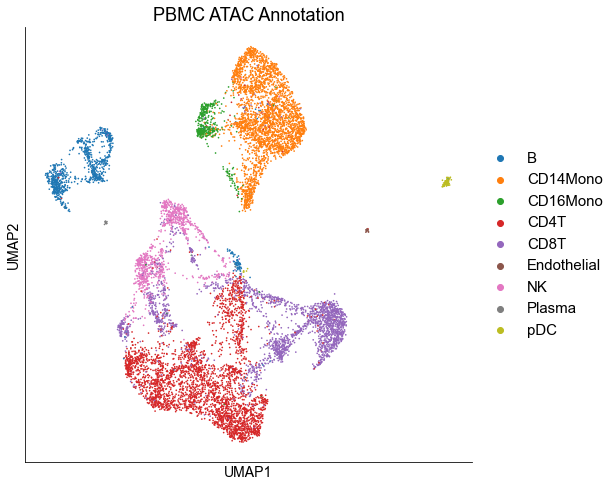

In [800]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(atac_adata, color=['Celltype'], title='PBMC ATAC Annotation',ax=ax)
fig.savefig(fname='Figures/PBMC_ATAC_annotation.pdf', format='pdf')

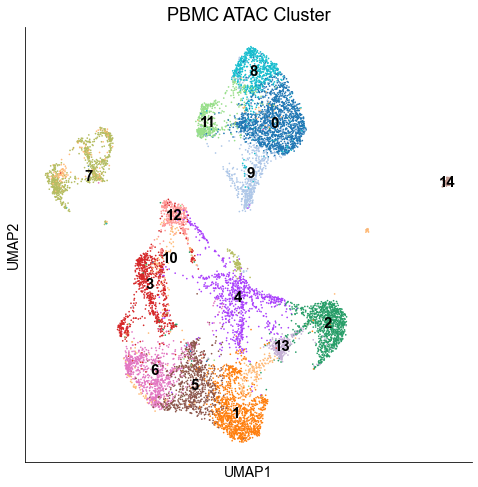

In [801]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(atac_adata, color=['seurat_clusters'], legend_loc='on data', title='PBMC ATAC Cluster',ax=ax)
fig.savefig(fname='Figures/PBMC_ATAC_cluster.pdf', format='pdf')

# Plot

## read data

In [ ]:
script_result_table = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/tf_cell_score_df.pk')

In [474]:
metadata = pd.read_csv('example/PBMC/analysis/metadata.txt', sep='\t', index_col=0)
metadata = atac_adata.obs.copy()

In [ ]:
metadata.loc[script_result_table.columns,:].sort_values(by='Celltype').index

In [11]:
expression = pd.read_csv('example/PBMC/cluster_expr.txt', sep='\t', index_col=0)

In [6]:
chromVAR_z_table = pd.read_csv('example/PBMC/chromVAR_ztable.txt', sep='\t').T

In [302]:
expression_table = rna_adata.to_df()

In [18]:
script_result_adata = ad.AnnData(script_result_table.T)
script_result_adata.obs['CellType'] = metadata.loc[script_result_adata.obs_names,'Celltype']
sc.tl.rank_genes_groups(script_result_adata, groupby='CellType')
# sc.pl.rank_genes_groups(script_result_adata, n_genes=25, sharey=False)

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/scanpy-1.8.1-py3.8.egg/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [188]:
hv_tf = []
for i in pd.DataFrame(script_result_adata.uns['rank_genes_groups']['names']).head(100).values:
    hv_tf += i.tolist()
hv_tf = list(set(hv_tf))
hv_tf.__len__()

595

In [189]:
bl = ['EGLN2', 'SRC', 'NCAPH2', 'ING2', 'KDM4B', 
      'ZNF76', 'FGFR1', 'XRN2', 'BRD2', 'BRPF3', 
      'AFF4', 'PCGF1', 'BRD1', 'NPAT', 
      'LEO1', 'CDK7', 'GLIS2', 'FAM208A', 'RYBP', 
      'KDM5B', 'CHD8', 'ZNF335', 'RBBP5',  'INTS12',  
      'POLR2AphosphoS5', 'IKZF2', 'SETD1A', 'ZXDB', 'WDR5', 
      'ASXL1', 'HMGN3', 'ARID2', 'ZBTB8A', 'RPE', 
      'INTS11', 'TAF3', 'INTS3', 'MAPK1', 'BRD3', 'EP400', 
      'CCNT2', 'KDM4C', 'KAT7', 'TAF1','KDM4A', 'ASCL2',
      'DDX21', 'POLR2B', 'ICE1', 'ARRB1', 'CBX1', 
      'HBP1', 'HEXIM1', 'MBTD1', 'CDK6', 'UHRF2', 
      'RBPJ', 'PRAME', 'RBP2', 'ZNF83', 'PRDM10', 
      'SUPT5H', 'RBL1', 'PHF8',  'ZNF501', 'JARID2', 'MTF2', 
      'CTBP1', 'NELFE', 'ZBTB14', 'GTF2B', 'SIN3A', 
      'RUVBL1', 'WDHD1', 'GRHL3', 'L3MBTL4', 'L3MBTL2', 
      'TAF7', 'ZNF580', 'ZFP2',  'TFDP1', 'AGO1', 
      'NKRF', 'ZNF101', 'KLF9', 'ASH2L', 'ZNF200']

In [190]:
for i in bl:
    if i in hv_tf:
        hv_tf.remove(i) 

In [191]:
hv_tf.__len__()

512

In [53]:
[i for i in hv_tf if i.startswith('BCL11')]

['BCL11A']

## heatmap

In [210]:
set(metadata.index[metadata['Celltype'] == 'NK']).intersection(script_result_table.columns).__len__()

In [132]:
random.seed(1024)
cell_type_bc = random.sample(set(metadata.index[metadata['Celltype'] == 'CD4T']).intersection(script_result_table.columns),2000)
random.seed(1025)
cell_type_bc += random.sample(set(metadata.index[metadata['Celltype'] == 'CD8T']).intersection(script_result_table.columns),1000)
random.seed(1026)
cell_type_bc += random.sample(set(metadata.index[metadata['Celltype'] == 'CD14Mono']).intersection(script_result_table.columns),1500)
random.seed(1027)
cell_type_bc += random.sample(set(metadata.index[metadata['Celltype'] == 'NK']).intersection(script_result_table.columns),1000)
# cell_type_bc += set(metadata.index[metadata['Celltype'] == 'Treg']).intersection(script_result_table.columns)
cell_type_bc += set(metadata.index[metadata['Celltype'] == 'CD16Mono']).intersection(script_result_table.columns)
cell_type_bc += set(metadata.index[metadata['Celltype'] == 'B']).intersection(script_result_table.columns)
# cell_type_bc += set(metadata.index[metadata['Celltype'] == 'Plasma']).intersection(script_result_table.columns)
cell_type_bc += set(metadata.index[metadata['Celltype'] == 'pDC']).intersection(script_result_table.columns)
# cell_type_bc += set(metadata.index[metadata['Celltype'] == 'DC']).intersection(script_result_table.columns)
cell_type_bc += set(metadata.index[metadata['Celltype'] == 'Endothelial']).intersection(script_result_table.columns)

In [68]:
colors_pla = {'CD4T':'#c53232', 
              'CD8T':'#ff66b5', 
              'NK':'#ff8363', 
              'Treg':'#c435d4', 
              'CD14Mono':'#EE8636', 
              'CD16Mono':'#eec636', 
              'B':'#3C75AF', 
              'Plasma':'#3c9aaf', 
              'DC':'#99f19c', 
              'pDC':'#F19D99', 
              'UNK1':'#F5BE82', 
              'UNK2':'#A8DD93', 
              'Endothelial':'#D57DBE'
             }

CellType = {'CD4T':'T', 
          'CD14Mono':'Mono', 
          'NK':'T', 
          'CD8T':'T', 
          'CD16Mono':'Mono', 
          'B':'B', 
          'pDC':'pDC', 
          'Plasma':'B', 
          'Endothelial':'Endothelial'
         }

rough_colors_pla = { 'T':'#C53932', 
                     'Mono':'#EE8636', 
                     'B':'#3C75AF', 
                     'DC':'#f7cf8d', 
                     'pDC': '#F19D99', 
                     'Endothelial':'#D57DBE'
                     }

metadata['Cell Type'] = metadata['Celltype'].map(CellType)


col_colors  = metadata.loc[cell_type_bc, 'Celltype'].map(colors_pla)
rough_col_colors = metadata.loc[cell_type_bc, 'Cell Type'].map(rough_colors_pla)

In [192]:
mark_tf = list(set(['TCF21', 'EBF1', 'BCL6', 'RUNX1', 'STAT5A','RELA','BATF','RUNX1','ETS1','EOMES',
           'NOTCH1', 'CD74', 'TCF12','BCL11B', 'NR3C1', 'YY1',
           'PAX5', 'CEBPA', 'LYL1', 'BCL3', 'SPI1', 'CEBPB','STAT6','ZEB2',
           'IRF8', 'HOXA9', 'IRF4', 'SKI', 'BCL6','NFATC1','JUNB',
           'MEF2B', 'SPIC', 'SP1','RAG2','JUN','TCF3',
           'GATA1', 'MSC', 'BCL11A', 'ELF4', 'MEIS1',
           'FOXO1', 'SPIB', 'IKZF1','LMO1', 'STAT3']))
for i in mark_tf:
    if i not in hv_tf:
        hv_tf.append(i)

In [193]:
heatmap_data = script_result_table.loc[hv_tf,cell_type_bc]

In [ ]:
fig = sns.clustermap(heatmap_data, 
                     figsize=(9,11.5),
                     metric="euclidean", 
                     robust=False,
                     xticklabels=False, 
                     yticklabels=False, 
                     cmap='RdYlBu_r', 
                     dendrogram_ratio=(0, 0), 
                     standard_scale=0,
                     cbar_pos=None,
                     col_colors=col_colors,
                    )

reordered_labels = heatmap_data.index[fig.dendrogram_row.reordered_ind].tolist()
use_labels = mark_tf
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]

fig.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

fig.ax_row_dendrogram.remove()
fig.ax_col_dendrogram.remove()

In [ ]:
fig.savefig(fname='Figures/PBMC_Heatmap.png', format='png', compress_level=0)

In [ ]:
# fig.savefig(fname='Figures/PBMC_Heatmap_high.png', format='png', compress_level=0)

## correlation

In [4]:
script_res_table = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/tf_cell_score_df.pk').T

In [7]:
chromVAR_z_table = chromVAR_z_table.reindex(index = chromVAR_z_table.index.sort_values(),columns = chromVAR_z_table.columns.sort_values())

In [10]:
expression_table = rna_adata.to_df()

In [13]:
keys.index = keys['ATAC']
chromVAR_z_table.index = keys.loc[chromVAR_z_table.index, 'RNA']

In [14]:
keys.index = keys['ATAC']
script_res_table.index = keys.loc[script_res_table.index, 'RNA']

In [ ]:
rna_index = set(chromVAR_z_table.index).intersection(expression_table.index).intersection(script_res_table.index)

In [ ]:
ovlp_factor = set(script_res_table.columns).intersection(chromVAR_z_table.columns).intersection(expression_table.columns)

In [18]:
data_dict = {}
for i in ovlp_factor:
    script_fc = scipy.stats.spearmanr(script_res_table.loc[rna_index,i], expression_table.loc[rna_index,i])[0]
    chromvar_fc = scipy.stats.spearmanr(chromVAR_z_table.loc[rna_index,i], expression_table.loc[rna_index,i])[0]
    data_dict[i] = {}
    data_dict[i]['SCRIP'] = script_fc
    data_dict[i]['chromVAR'] = chromvar_fc

In [20]:
data_df = pd.DataFrame(data_dict).T

In [742]:
print(data_df.index[(data_df['SCRIP'] > 0) & (data_df['chromVAR'] > 0)].__len__())
print(data_df.index[(data_df['SCRIP'] < 0) & (data_df['chromVAR'] < 0)].__len__())

print(data_df.index[(data_df['SCRIP'] < 0) & (data_df['chromVAR'] > 0)].__len__())
print(data_df.index[(data_df['SCRIP'] > 0) & (data_df['chromVAR'] < 0)].__len__())

164
124
67
113


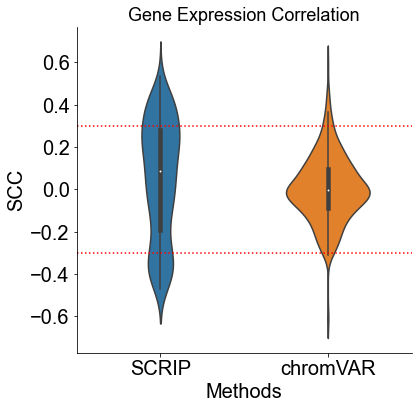

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
sns.violinplot(data=data_df, width=0.5, fliersize=3)
ax.axhline(y=0.3, ls=":", c="red")
ax.axhline(y=-0.3, ls=":", c="red")
ax.set_xlabel('Methods', fontsize=20)
ax.set_ylabel('SCC', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_title('Gene Expression Correlation')
fig.show()
fig.savefig(fname='Figures/RNA_Correlation_boxplot.pdf', format='pdf', bbox_inches='tight')

In [897]:
ctof = 0.3
barplot_df = pd.DataFrame({0:{'Count': data_df[data_df['SCRIP']>ctof].__len__(), 'Method': 'SCRIP', 'Correlation': '> 0.3'}, 
             1:{'Count': data_df[data_df['chromVAR']>ctof].__len__(), 'Method': 'chromVAR', 'Correlation': '> 0.3'}, 
             2:{'Count': data_df[data_df['SCRIP'] < -ctof].__len__(), 'Method': 'SCRIP', 'Correlation': '< -0.3'}, 
             3:{'Count': data_df[data_df['chromVAR'] < -ctof].__len__(), 'Method': 'chromVAR', 'Correlation': '< -0.3'}, 
             }).T

In [898]:
barplot_df

Count    Method Correlation
0    99     SCRIP       > 0.3
1    17  chromVAR       > 0.3
2    88     SCRIP      < -0.3
3     5  chromVAR      < -0.3

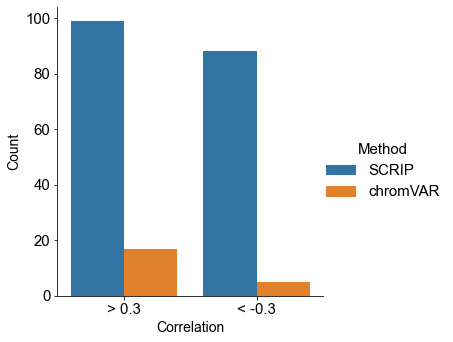

In [900]:
g = sns.catplot(data=barplot_df, kind='bar', x='Correlation', y='Count', hue='Method')
g.savefig(fname='Figures/Correlation_count_0.3.pdf', format='pdf', bbox_inches='tight')
# g.set_xticklabels(rotation=30)

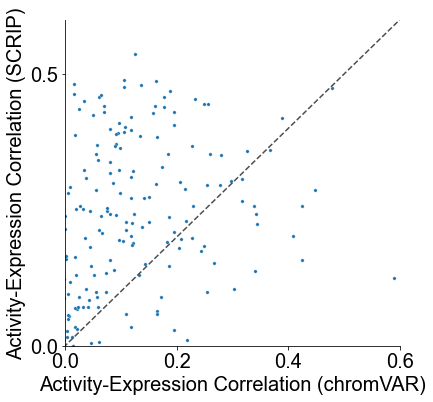

In [747]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=data_df, x='chromVAR', y='SCRIP', s=12, ax=ax)
ax.plot([-0.6, 0.6], [-0.6, 0.6], ls="--", c=".3")
ax.set_xlabel('Activity-Expression Correlation (chromVAR)', fontsize=20)
ax.set_ylabel('Activity-Expression Correlation (SCRIP)', fontsize=20)
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)
ymajorLocator = MultipleLocator(0.5)
ax.yaxis.set_major_locator(ymajorLocator)
ax.tick_params(labelsize=20)
fig.savefig(fname='Figures/RNA_Correlation_greater0.pdf', format='pdf', bbox_inches='tight')

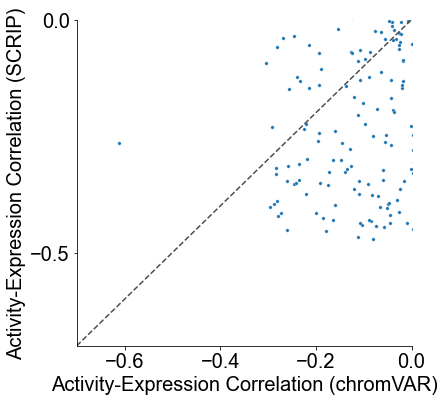

In [750]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=data_df, x='chromVAR', y='SCRIP', s=12, ax=ax)
ax.plot([-0.7, 0.7], [-0.7, 0.7], ls="--", c=".3")
ax.set_xlabel('Activity-Expression Correlation (chromVAR)', fontsize=20)
ax.set_ylabel('Activity-Expression Correlation (SCRIP)', fontsize=20)
ax.set_xlim(-0.7,0)
ax.set_ylim(-0.7,0)
ymajorLocator = MultipleLocator(0.5)
ax.yaxis.set_major_locator(ymajorLocator)
ax.tick_params(labelsize=20)
fig.savefig(fname='Figures/RNA_Correlation_less0.pdf', format='pdf', bbox_inches='tight')

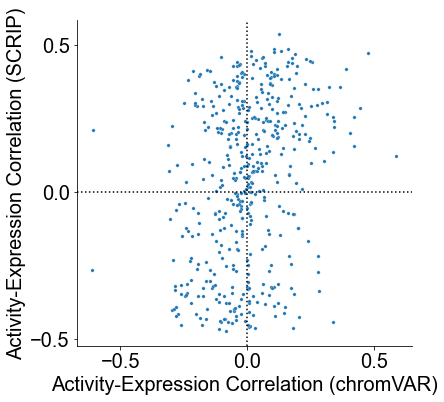

In [751]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=data_df, x='chromVAR', y='SCRIP', s=12, ax=ax)
# ax.plot([-0.7, 0.7], [-0.7, 0.7], ls="--", c=".3")
ax.axvline(x=0, ls=":", c="black")
ax.axhline(y=0, ls=":", c="black")
ax.set_xlabel('Activity-Expression Correlation (chromVAR)', fontsize=20)
ax.set_ylabel('Activity-Expression Correlation (SCRIP)', fontsize=20)
ymajorLocator = MultipleLocator(0.5)
ax.yaxis.set_major_locator(ymajorLocator)
ax.tick_params(labelsize=20)
fig.savefig(fname='Figures/RNA_Correlation.pdf', format='pdf', bbox_inches='tight')

### SCRIPT chromVAR Expression

In [695]:
chromVAR_z_table = pd.read_csv('example/PBMC/chromVAR_ztable.txt', sep='\t').T

In [696]:
script_res_table = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/tf_cell_score_df.pk').T

In [ ]:
chromVAR_dict = {}
SCRIP_dict = {}
for i in mean_expr_dict_df.columns:
    locals()[i+'_cells'] = set(metadata[(metadata['Celltype'] == i)].index).intersection(chromVAR_z_table.index).intersection(script_res_table.index)
    locals()[i] = chromVAR_z_table.loc[locals()[i+'_cells'],].mean()
    chromVAR_dict[i] = locals()[i]
    locals()[i] = script_res_table.loc[locals()[i+'_cells'],].mean()
    SCRIP_dict[i] = locals()[i]

In [705]:
SCRIP_table = pd.DataFrame(SCRIP_dict)
chromVAR_table = pd.DataFrame(chromVAR_dict)

In [ ]:
for i in mean_expr_dict_df.columns:
    expression_sub = mean_expr_dict_df.loc[ovlp_factor, i]
    chromVAR_sub = chromVAR_table.loc[ovlp_factor, i]
    SCRIP_sub = SCRIP_table.loc[ovlp_factor, i]
    locals()[i+'_table'] = pd.DataFrame({'expression':expression_sub, 'chromVAR':chromVAR_sub, 'SCRIP':SCRIP_sub})

In [ ]:
for cell in SCRIP_table.columns:
    # cell = 'pDC'
    data = locals()[cell + "_table"]
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    sns.scatterplot(data=data, y='chromVAR', x='SCRIP', hue='expression', palette='RdBu_r', ax=ax, legend=False)
    ax.set_title('%s Cell' % cell, fontsize=23)
    texts = []
    for i in range(len(data.index)):
        if data.iloc[i,1] > np.quantile(data.iloc[:,1],0.99) or data.iloc[i,2] > np.quantile(data.iloc[:,2],0.99):
            texts.append(plt.text(data.iloc[i,2], data.iloc[i,1], data.index[i], size=15, 
                                  bbox={'facecolor': '#F2F2F2', 
                                        'edgecolor': '#F2F2F2',
                                        'alpha': 0.5,
                                        'pad': 0.1,
                                        'boxstyle':'round'
                                        }))
#     for i in data.index:
#         if i in ['BCL11A', 'BCL11B', 'CEBPA','CEBPB','EBF1','PAX5','GATA3','JUN', 'STAT1', 'TBX21', 'YY1', 'STAT6', 'FOXP3', 'RELA', 'JUNB', 'IRF4', 'FOXO1']:
#             texts.append(plt.text(data.loc[i,'SCRIPT'], data.loc[i,'ChromVAR'], i, size=10))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))
    fig.show()
    fig.savefig(fname='Figures/PBMC_%s_cell_TF_chromVAR_vs_SCRIPT_new.pdf' % cell, transparent=True, bbox_inches='tight', pad_inches=0.5)

## plot different factor

In [ ]:
atac_adata = atac_adata[script_res_table.index,]

In [752]:
atac_adata.obs = pd.concat([atac_adata.obs, script_res_table.loc[atac_adata.obs_names,:]], axis=1)

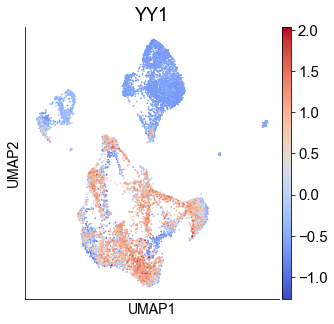

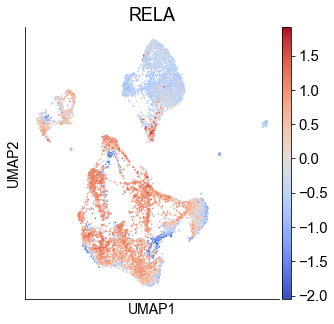

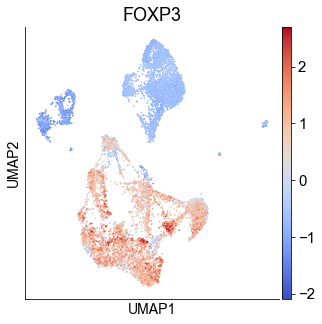

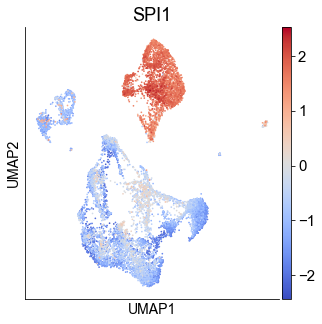

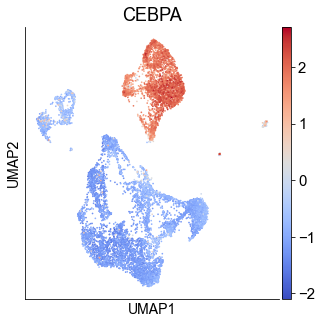

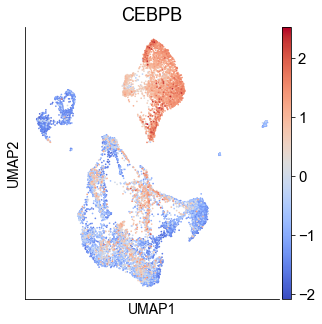

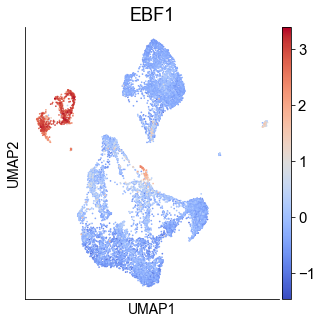

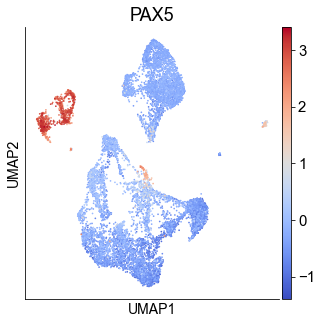

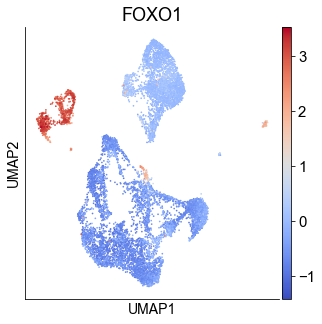

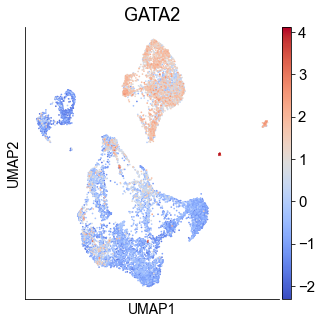

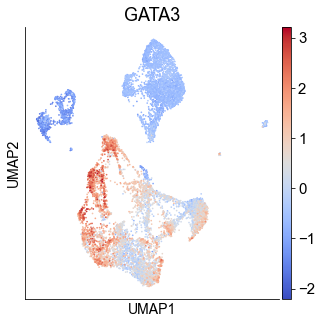

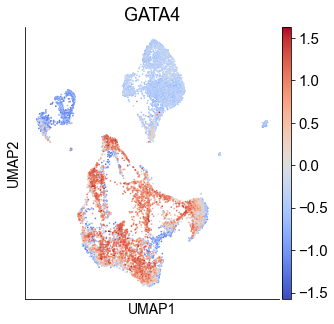

In [790]:
for tf in ['YY1', 'RELA', 'FOXP3', 'SPI1', 'CEBPA', 'CEBPB', 'EBF1', 'PAX5', 'FOXO1', 'GATA2', 'GATA3', 'GATA4']:
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    sc.pl.umap(atac_adata, color=[tf], cmap='coolwarm', ax=ax)
    fig.savefig(fname='Figures/PBMC_SCRIPT_%s.png' % tf, format='png')

## similar motif

In [ ]:
atac_adata = atac_adata[script_res_table.index,]

In [804]:
atac_adata.obs['chromVAR_BCL11A'] = chromVAR_z_table.loc[atac_adata.obs_names,'BCL11A']
atac_adata.obs['chromVAR_BCL11B'] = chromVAR_z_table.loc[atac_adata.obs_names,'BCL11B']

Trying to set attribute `.obs` of view, copying.


In [805]:
atac_adata.obs['SCRIP_BCL11A'] = script_res_table.loc[atac_adata.obs_names,'BCL11A']
atac_adata.obs['SCRIP_BCL11B'] = script_res_table.loc[atac_adata.obs_names,'BCL11B']

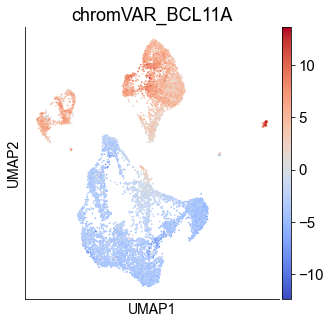

In [806]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(atac_adata, color=['chromVAR_BCL11A'], cmap='coolwarm', ax=ax)
fig.savefig(fname='Figures/PBMC_chromVAR_BCL11A_comparison.pdf', format='pdf')

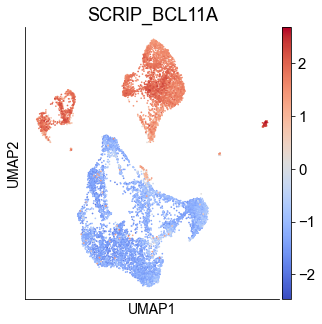

In [807]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(atac_adata, color=['SCRIP_BCL11A'], cmap='coolwarm', ax=ax)
fig.savefig(fname='Figures/PBMC_SCRIPT_BCL11A_comparison.pdf', format='pdf')

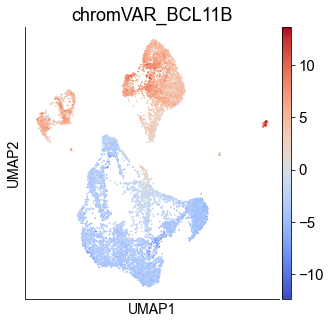

In [808]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(atac_adata, color=['chromVAR_BCL11B'], cmap='coolwarm', ax=ax)
fig.savefig(fname='Figures/PBMC_chromVAR_BCL11B_comparison.pdf', format='pdf')

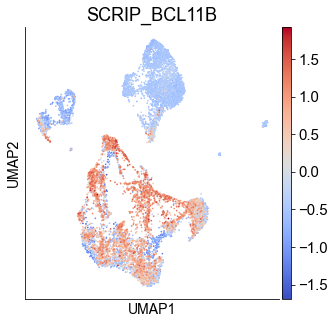

In [809]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(atac_adata, color=['SCRIP_BCL11B'], cmap='coolwarm', ax=ax)
fig.savefig(fname='Figures/PBMC_SCRIPT_BCL11B_comparison.pdf', format='pdf')

## NMI ARI

In [774]:
ari_nmi_data_df = pd.DataFrame({0:{'Value':0.625, 'Method': 'SCRIP', 'Evaluation': 'NMI'},
                        1:{'Value':0.596, 'Method': 'chromVAR', 'Evaluation': 'NMI'},
                        2:{'Value':0.6044, 'Method': 'SCALE', 'Evaluation': 'NMI'},
                        3:{'Value':0.533, 'Method': 'Signac', 'Evaluation': 'NMI'},
                        4:{'Value':0.492, 'Method': 'CisTopic', 'Evaluation': 'NMI'},
                        5:{'Value':0.534, 'Method': 'ArchR', 'Evaluation': 'NMI'},
                        6:{'Value':0.463, 'Method': 'SnapATAC', 'Evaluation': 'NMI'},
                        7:{'Value':0.529, 'Method': 'SCRIP', 'Evaluation': 'ARI'},
                        8:{'Value':0.462, 'Method': 'chromVAR', 'Evaluation': 'ARI'},
                        9:{'Value':0.419, 'Method': 'SCALE', 'Evaluation': 'ARI'},
                        10:{'Value':0.455, 'Method': 'Signac', 'Evaluation': 'ARI'},
                        11:{'Value':0.253, 'Method': 'CisTopic', 'Evaluation': 'ARI'},
                        12:{'Value':0.228, 'Method': 'ArchR', 'Evaluation': 'ARI'},
                        13:{'Value':0.133, 'Method': 'SnapATAC', 'Evaluation': 'ARI'}  
                       }).T

In [584]:
ari_nmi_data_df

Value    Method Evaluation
0    0.625     SCRIP        NMI
1    0.596  chromVAR        NMI
2   0.6044     SCALE        NMI
3    0.533    Signac        NMI
4    0.492  CisTopic        NMI
5    0.534     ArchR        NMI
6    0.463  SnapATAC        NMI
7    0.529     SCRIP        ARI
8    0.462  chromVAR        ARI
9    0.419     SCALE        ARI
10   0.455    Signac        ARI
11   0.253  CisTopic        ARI
12   0.228     ArchR        ARI
13   0.133  SnapATAC        ARI

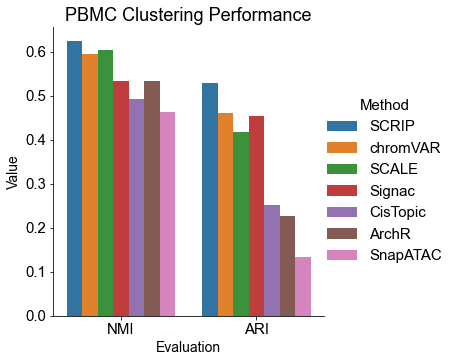

In [775]:
g = sns.catplot(data=ari_nmi_data_df, kind='bar', x='Evaluation', y='Value', hue='Method').set(title='PBMC Clustering Performance')

# g = sns.catplot(data=ari_nmi_data_df, kind='bar', x='Evaluation', y='Value', hue='Method')
g.savefig('Figures/NMI_methods_compare.pdf')
# g.set_titles('PBMC Clustering Performance')
# g.show()
# g = sns.catplot(data=plt_data, kind="bar", x="Evaluation", y="Value", hue="Method")

In [579]:
sns.color_palette()[0:7]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

In [776]:
ari_nmi_data_df = pd.DataFrame({0:{'Value':0.452, 'Method': 'SCRIP', 'Evaluation': 'NMI'},
                        1:{'Value':0.445, 'Method': 'chromVAR', 'Evaluation': 'NMI'},
                        3:{'Value':0.4, 'Method': 'Signac', 'Evaluation': 'NMI'},
                        4:{'Value':0.443, 'Method': 'CisTopic', 'Evaluation': 'NMI'},
                        5:{'Value':0.551, 'Method': 'ArchR', 'Evaluation': 'NMI'},
                        6:{'Value':0.424, 'Method': 'SnapATAC', 'Evaluation': 'NMI'},
                        7:{'Value':0.295, 'Method': 'SCRIP', 'Evaluation': 'ARI'},
                        8:{'Value':0.262, 'Method': 'chromVAR', 'Evaluation': 'ARI'},
                        10:{'Value':0.228, 'Method': 'Signac', 'Evaluation': 'ARI'},
                        11:{'Value':0.274, 'Method': 'CisTopic', 'Evaluation': 'ARI'},
                        12:{'Value':0.328, 'Method': 'ArchR', 'Evaluation': 'ARI'},
                        13:{'Value':0.21, 'Method': 'SnapATAC', 'Evaluation': 'ARI'}  
                       }).T

In [591]:
ari_nmi_data_df

Value    Method Evaluation
0   0.452     SCRIP        NMI
1   0.445  chromVAR        NMI
3     0.4    Signac        NMI
4   0.443  CisTopic        NMI
5   0.551     ArchR        NMI
6   0.424  SnapATAC        NMI
7   0.295     SCRIP        ARI
8   0.262  chromVAR        ARI
10  0.228    Signac        ARI
11  0.274  CisTopic        ARI
12  0.328     ArchR        ARI
13   0.21  SnapATAC        ARI

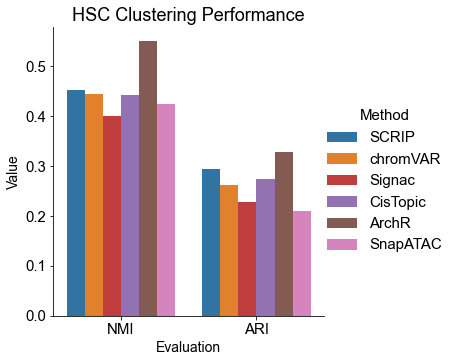

In [777]:
g = sns.catplot(data=ari_nmi_data_df, kind='bar', x='Evaluation', y='Value', hue='Method', palette=[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]).set(title='HSC Clustering Performance')
g.savefig('Figures/HSC_NMI_methods_compare.pdf')

In [379]:
atac_adata.obs = pd.concat([atac_adata.obs, script_result_table.T], axis=1)

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


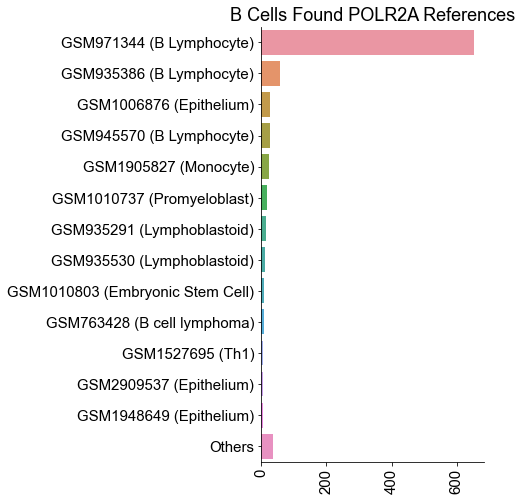

In [605]:
B_bc = set(metadata.index[metadata['Celltype'] == 'B']).intersection(tmp.columns)
source_stas_B = tmp.loc['POLR2A',B_bc].value_counts()
fig, ax = plt.subplots(figsize=(4,8))

for break_index,j in enumerate(source_stas_B.values):
    if j < 5:
        break

data = list(source_stas_B.values[0:break_index])
labels = [data_source[data_source['DCid'] == int(i.split('_')[1])]['GSMID'].values[0] + ' (' + data_source[data_source['DCid'] == int(i.split('_')[1])]['Cell_type'].values[0] + ')' for i in source_stas_B.index[0:break_index]]

data.append(source_stas_B.values[break_index:].sum())
labels.append('Others')

sns.barplot(data, labels, orient='h')
ax.tick_params(axis='x', rotation=90)
ax.set_title('B Cells Found POLR2A References')
fig.show()
fig.savefig('../../Figures/Reference_B_cell_new.pdf', format='pdf')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


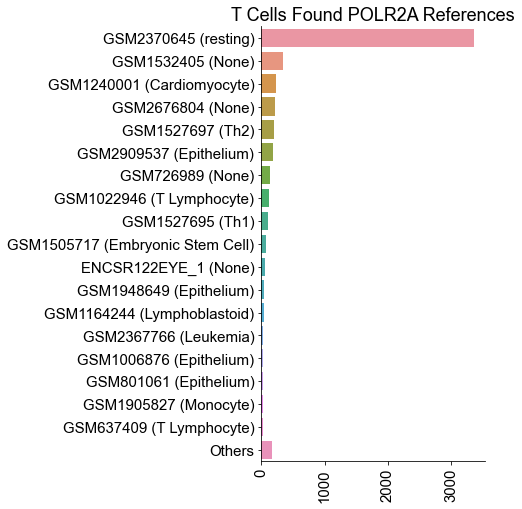

In [604]:
T_bc = set(metadata.index[(metadata['Celltype'] == 'CD4T') | (metadata['Celltype'] == 'CD8T')]).intersection(tmp.columns)
source_stas_T = tmp.loc['POLR2A',T_bc].value_counts()
fig, ax = plt.subplots(figsize=(4,8))

for break_index,j in enumerate(source_stas_T.values):
    if j < 20:
        break

data = list(source_stas_T.values[0:break_index])
labels = [data_source[data_source['DCid'] == int(i.split('_')[1])]['GSMID'].values[0] + ' (' + data_source[data_source['DCid'] == int(i.split('_')[1])]['Cell_type'].values[0] + ')' for i in source_stas_T.index[0:break_index]]

data.append(source_stas_T.values[break_index:].sum())
labels.append('Others')

sns.barplot(data, labels, orient='h')
ax.tick_params(axis='x', rotation=90)
ax.set_title('T Cells Found POLR2A References')
fig.show()
fig.savefig('../../Figures/Reference_T_cell_new.pdf', format='pdf')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


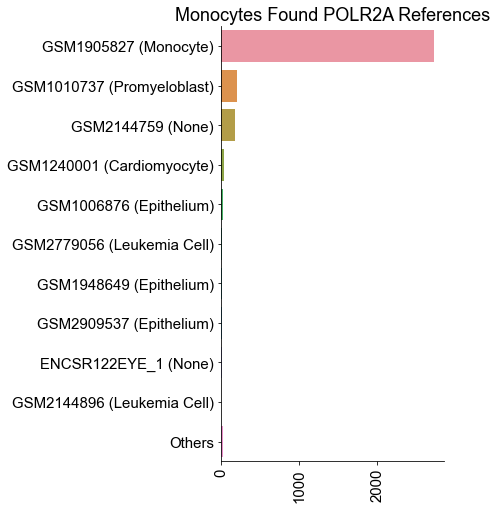

In [609]:
mono_bc = set(metadata.index[(metadata['Celltype'] == 'CD14Mono') | (metadata['Celltype'] == 'CD16Mono')]).intersection(tmp.columns)
source_stas_mono = tmp.loc['POLR2A',mono_bc].value_counts()
fig, ax = plt.subplots(figsize=(4,8))

for break_index,j in enumerate(source_stas_mono.values):
    if j < 5:
        break

data = list(source_stas_mono.values[0:break_index])
labels = [data_source[data_source['DCid'] == int(i.split('_')[1])]['GSMID'].values[0] + ' (' + data_source[data_source['DCid'] == int(i.split('_')[1])]['Cell_type'].values[0] + ')' for i in source_stas_mono.index[0:break_index]]

data.append(source_stas_mono.values[break_index:].sum())
labels.append('Others')

sns.barplot(data, labels, orient='h')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Monocytes Found POLR2A References')
fig.show()
fig.savefig('../../Figures/Reference_mono_cell_new.pdf', format='pdf')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


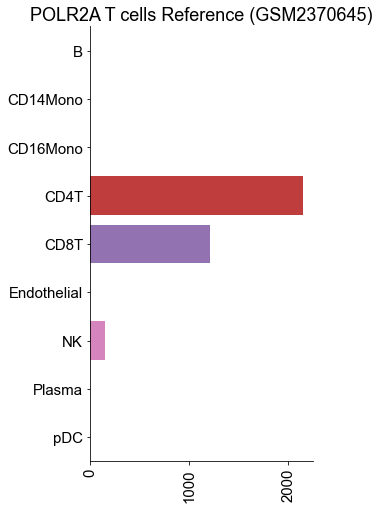

In [610]:
source_stas_73734 = metadata.loc[tmp.loc['POLR2A'][tmp.loc['POLR2A'] == 'POLR2A_73734'].index,'Celltype'].value_counts()

fig, ax = plt.subplots(figsize=(4,8))
sns.barplot(source_stas_73734.values, source_stas_73734.index, orient='h')
ax.tick_params(axis='x', rotation=90)
ax.set_title('POLR2A T cells Reference (GSM2370645)')
fig.show()
fig.savefig('../../Figures/Reference_T_cell.pdf', format='pdf')

In [807]:
source = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_score_source_df.pk')

In [808]:
score = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_overlap_df.pk')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


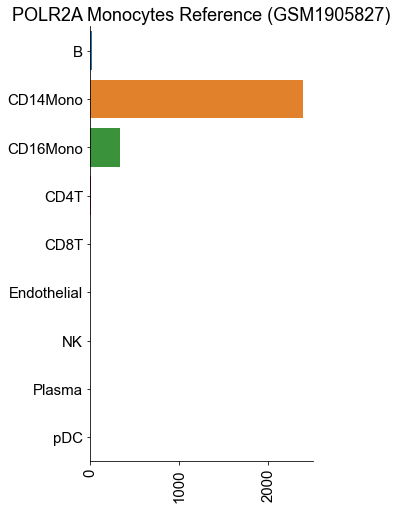

In [612]:
source_stas_59044 = metadata.loc[tmp.loc['POLR2A'][tmp.loc['POLR2A'] == 'POLR2A_59044'].index,'Celltype'].value_counts()

fig, ax = plt.subplots(figsize=(4,8))
sns.barplot(source_stas_59044.values, source_stas_59044.index, orient='h')
plt.xticks(rotation=90)
ax.set_title('POLR2A Monocytes Reference (GSM1905827)')
fig.show()
fig.savefig('../../Figures/Reference_Monocytes.pdf', format='pdf')

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/seaborn-0.11.2-py3.8.egg/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


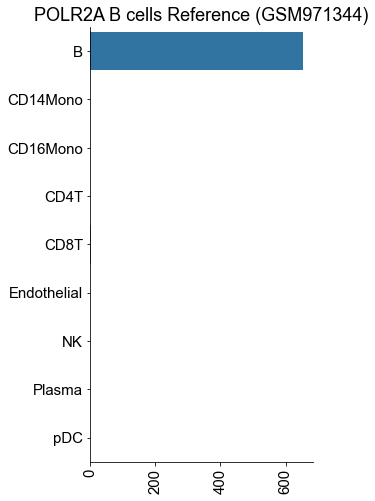

In [613]:
source_stas_33439 = metadata.loc[tmp.loc['POLR2A'][tmp.loc['POLR2A'] == 'POLR2A_33439'].index,'Celltype'].value_counts()

fig, ax = plt.subplots(figsize=(4,8))
sns.barplot(source_stas_33439.values, source_stas_33439.index,orient='h')
plt.xticks(rotation=90)
ax.set_title('POLR2A B cells Reference (GSM971344)')
fig.show()
fig.savefig('../../Figures/Reference_B_cell.pdf', format='pdf')

## cell type score
### corresponding cell type

In [4]:
score = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_overlap_df.pk')

In [616]:
qpeak_length = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/qpeaks_length.txt', index_col=0, header=None, sep='\t')/1e8

In [812]:
metadata = pd.read_csv('example/PBMC/analysis/metadata.txt', sep='\t', index_col=0)

In [615]:
def standardScaler(t):
    scaler = preprocessing.StandardScaler().fit(t)
    rt = pd.DataFrame(scaler.transform(t), index=t.index, columns=t.columns)
    return rt

def cal_score(dataset_overlap_df, peaks_number, qpeak_length):
    '''
    nql: normalize query peak length
    dm: minus the mean
    '''
    dataset_cell_percent = (dataset_overlap_df.T/peaks_number.loc[dataset_overlap_df.index, 1]).T
    dataset_cell_percent_dl = dataset_cell_percent/qpeak_length.loc[dataset_cell_percent.columns, 1]
    dataset_cell_percent_dl_dm = (dataset_cell_percent_dl.T - dataset_cell_percent_dl.mean(1)).T
    # dataset_cell_percent_scale = (dataset_cell_percent/dataset_cell_percent.sum())*1e4
    # dataset_cell_percent_scale_dm = (dataset_cell_percent_scale.T/dataset_cell_percent_scale.mean(1)).T
    return dataset_cell_percent_dl_dm

def score_normalization(dataset_cell_df):
    tf_cell_df = map_factor_on_ChIP(dataset_cell_df)
    tmp = standardScaler(tf_cell_df.T).T
    tf_cell_df_lsn = 1/(1+np.exp(-tmp))  # LSN(Logistic Sigmoid Normalisation)
    tf_cell_df_lsn_std = standardScaler(tf_cell_df_lsn)
    return tf_cell_df_lsn_std

def map_factor_on_ChIP(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    factor_table = ret_table.groupby("Factor").max()
    return factor_table

def get_factor_source(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    max_index = ret_table.groupby("Factor").idxmax()
    return max_index

def umap_table(script_table_cell_tf, metadata):
    sudo_expression_SCRIPT = ad.AnnData(script_table_cell_tf)
#     sc.pp.highly_variable_genes(sudo_expression_SCRIPT)
#     sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack', use_highly_variable=False)
    sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
    sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=9, n_pcs=40)
    sc.tl.umap(sudo_expression_SCRIPT)
    sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
    sudo_expression_SCRIPT.obs['real_cell_type']=metadata['Celltype'][sudo_expression_SCRIPT.obs.index]
#     sudo_expression_SCRIPT.obs['nFeature_ATAC']=metadata['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]
    sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type'], color_map=regulation_cmp)
    print('NMI = ', sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['real_cell_type'], sudo_expression_SCRIPT.obs['louvain']))
    print('ARI = ', sklearn.metrics.adjusted_rand_score(sudo_expression_SCRIPT.obs['real_cell_type'], sudo_expression_SCRIPT.obs['louvain']))
    return sudo_expression_SCRIPT

In [619]:
blood_type_list = ['Fibroblast', 'T Lymphocyte','Lymphocyte', 'B Lymphocyte', 'Haematopoietic Progenitor Cell','Erythroblast', 'Promyelocytic cell', 'Proerythroblast','Lymphoblastoid','B cell lymphoma', 'Myeloblast',
                    'T cell leukemia', 'Pre-B Lymphocyte','Hematopoietic Cell', 'Th1', 'Th2', 'Plasma Cell', 'Monocyte','Macrophage', 'CD14 cell', 'Leukemia Cell',
                    'Erythroid Cell','Myeloid Cell', 'Erythroid Progenitor Cell', 'Leukemic Blast Cell','T Lymphoblast', 'Hematopoietic Stem Cell',
                    'B cell precursor', 'Thymocyte', 'Megakaryoblastic', 'B Lymphoblast','Hematopoietic stem and progenitor cell', 
                    'Acute myeloid leukemia', 'Lymphoblast','fibrobasts','Erythroid progenitor', 'Leukemic cells', 'Plasmacytoid dendritic cell','Leukemia','AML cell','resting']

In [620]:
blood_tissue_list = ['Blood',  'Bone Marrow',  'Lymph Node', 'Cord blood', 'Peripheral Blood', 'Spleen','Thymus','Haematopoietic and lymphoid']

In [621]:
name_list = []
for i in range(data_source.loc[:,['DCid','Factor','Cell_type']].__len__()):
#     if data_source.loc[i,'Cell_type'] in blood_type_list :
    if data_source.loc[i,'Cell_type'] in blood_type_list or data_source.loc[i,'Tissue_type'] in blood_tissue_list :
        name = data_source.loc[i,'Factor'] + '_' + str(data_source.loc[i,'DCid'])
        name_list.append(name)

for i in ['TERF2_50971', 'COPS2_62811', 'POLR3D_68066', 'ZNF75A_77265', 'ZNF410_77269']:        
    name_list.remove(i)

In [622]:
peaks_number_path = '/fs/home/dongxin/Projects/SCRIPT/indices/human/tf_chip_qc_5fold_motif_giggle/peaks_number.txt'
peaks_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)
peaks_number = peaks_number.loc[name_list,:]

In [625]:
cell_type_score = score.loc[name_list,:].copy()

In [637]:
celltype_final_enrich = score_normalization(cal_score(cell_type_score, peaks_number, qpeak_length))

In [638]:
celltype_final_enrich.index.__len__()

340

In [639]:
def map_factor_on_ChIP(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    factor_table = ret_table.groupby("Factor").mean()
    return factor_table

computing PCA
    with n_comps=50
    finished (0:00:00)


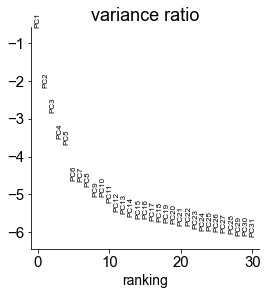

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


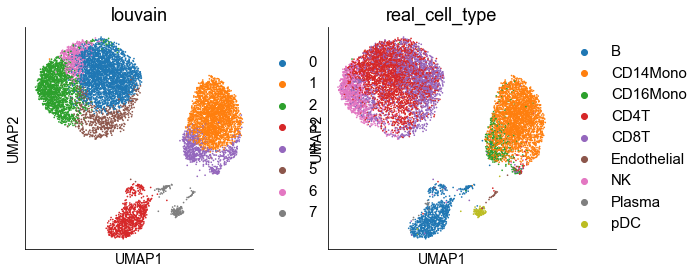

NMI =  0.5941017651528746
ARI =  0.4731340230810719


In [640]:
cell_type_adata = umap_table(celltype_final_enrich.T, metadata)

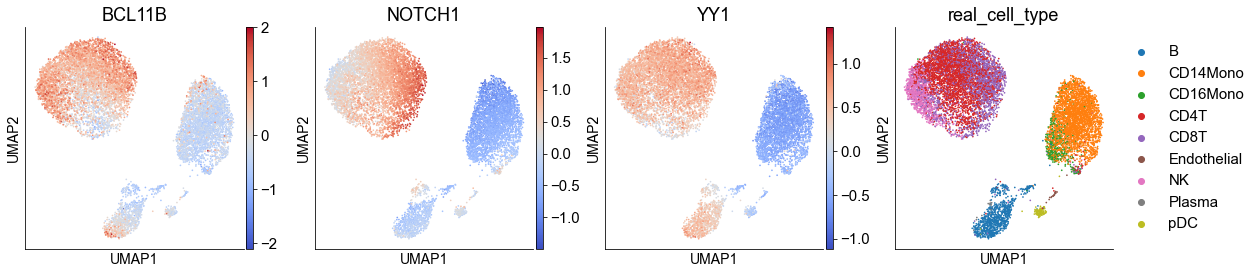

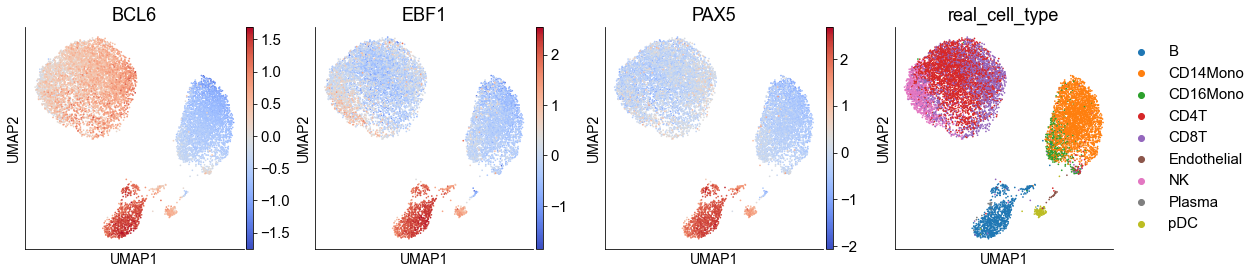

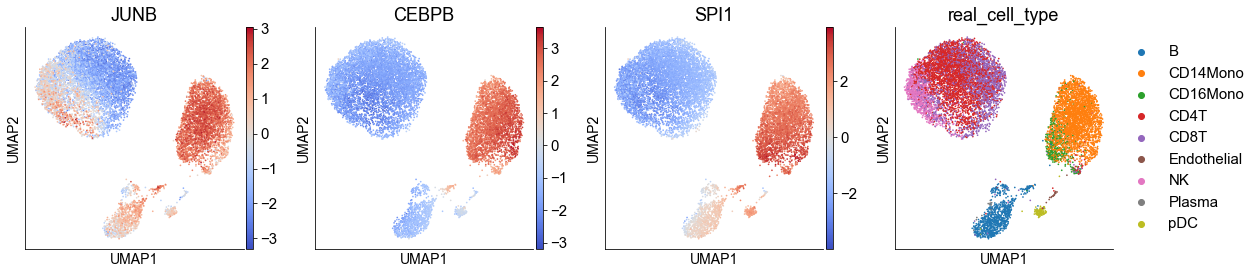

In [641]:
sc.pl.umap(cell_type_adata, color=['BCL11B', 'NOTCH1', 'YY1', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(cell_type_adata, color=['BCL6', 'EBF1', 'PAX5', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(cell_type_adata, color=['JUNB', 'CEBPB', 'SPI1', 'real_cell_type'], cmap='coolwarm')

### mean value

In [825]:
peaks_number_path = '/fs/home/dongxin/Projects/SCRIPT/indices/human/tf_chip_qc_5fold_motif_giggle/peaks_number.txt'
peaks_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)

In [826]:
datasets_celltype_list = [i for i in score.index if i.split('_')[0] in celltype_final_enrich.index]

In [827]:
score_340factor = score.loc[datasets_celltype_list,:]

In [634]:
def map_factor_on_ChIP(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    factor_table = ret_table.groupby("Factor").mean()
    return factor_table

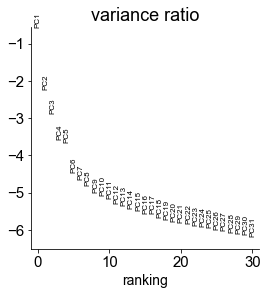

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_cell_type' as categorical


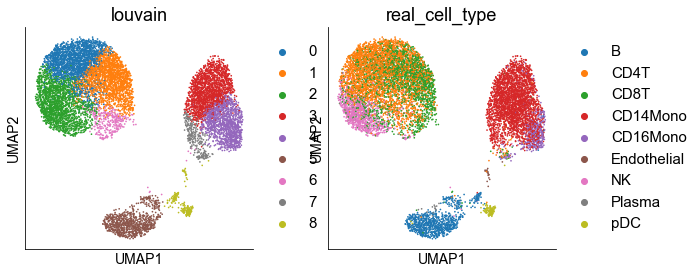

NMI =  0.5694341475826487
ARI =  0.3888678260006303


In [843]:
mean_score_340factor = score_normalization(cal_score(score_340factor, peaks_number, qpeak_length))
mean_adata = umap_table(mean_score_340factor.T, metadata)

computing PCA
    with n_comps=50
    finished (0:00:00)


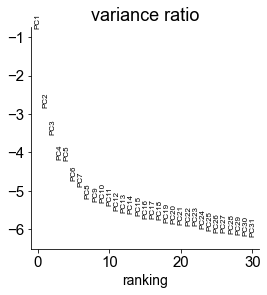

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


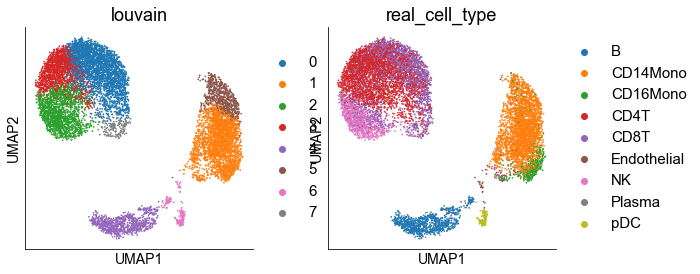

NMI =  0.5922649962908474
ARI =  0.43675003358489983


In [635]:
mean_score_340factor = score_normalization(cal_score(score, peaks_number, qpeak_length))
mean_adata = umap_table(mean_score_340factor.T, metadata)

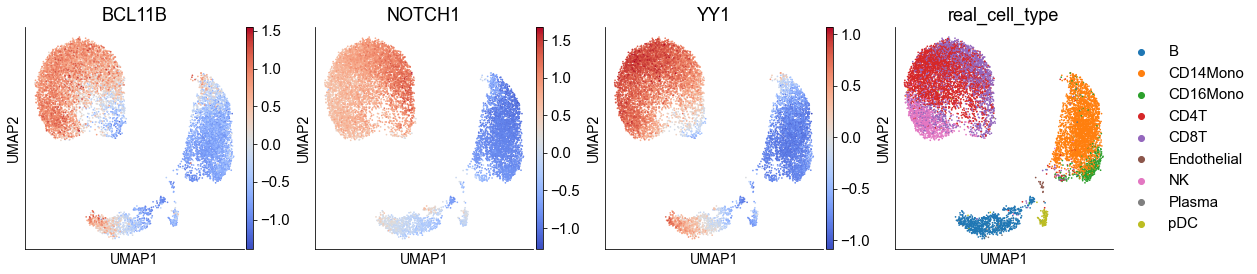

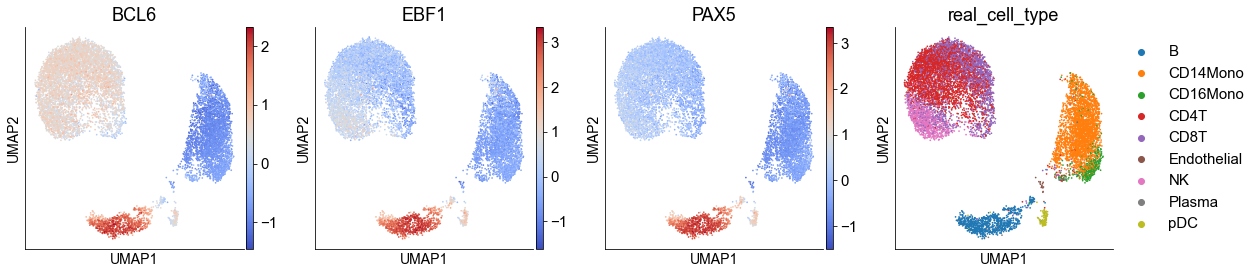

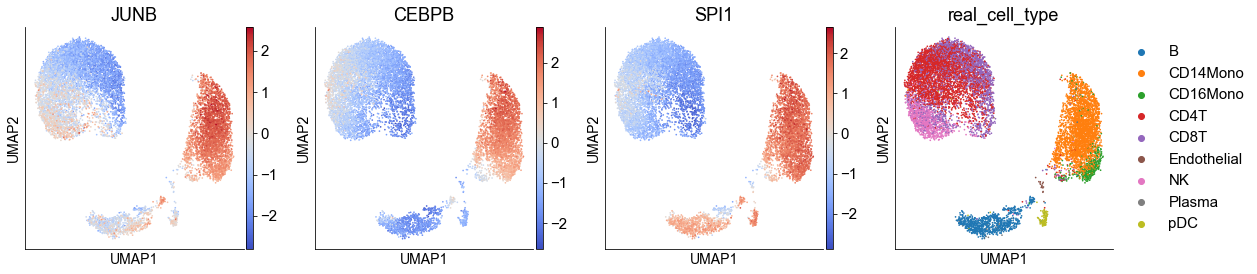

In [636]:
sc.pl.umap(mean_adata, color=['BCL11B', 'NOTCH1', 'YY1', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(mean_adata, color=['BCL6', 'EBF1', 'PAX5', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(mean_adata, color=['JUNB', 'CEBPB', 'SPI1', 'real_cell_type'], cmap='coolwarm')

### max value

In [628]:
peaks_number_path = '/fs/home/dongxin/Projects/SCRIPT/indices/human/tf_chip_qc_5fold_motif_giggle/peaks_number.txt'
peaks_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)

In [ ]:
score_340factor = score.loc[datasets_celltype_list,:]

In [631]:
def map_factor_on_ChIP(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    factor_table = ret_table.groupby("Factor").max()
    return factor_table

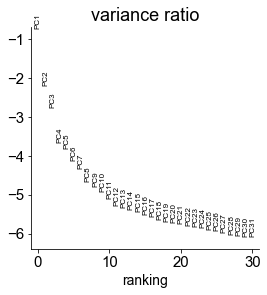

/fs/home/dongxin/Applications/miniconda3/envs/SCRIPT/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_cell_type' as categorical


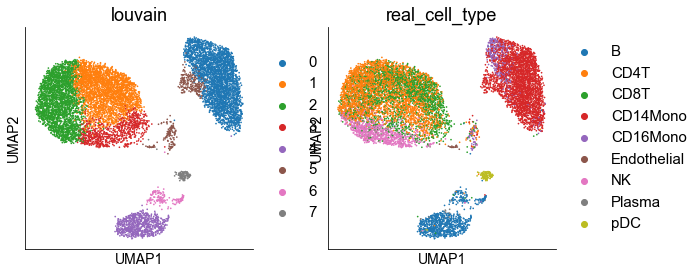

NMI =  0.580413913986108
ARI =  0.46213051982903147


In [841]:
max_score_340factor = score_normalization(cal_score(score_340factor, peaks_number, qpeak_length))
max_adata = umap_table(max_score_340factor.T, metadata)

computing PCA
    with n_comps=50
    finished (0:00:00)


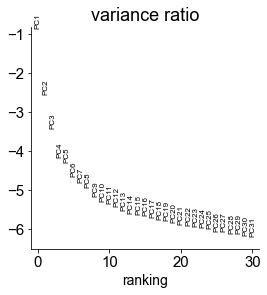

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


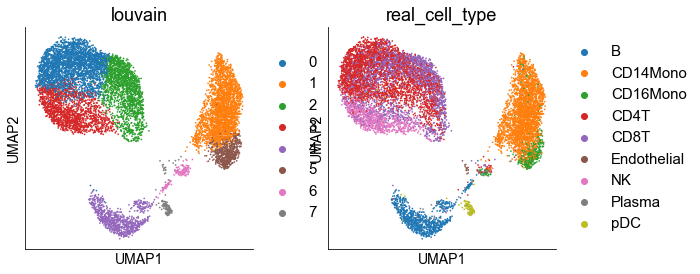

NMI =  0.6246759745391729
ARI =  0.5282450451124835


In [632]:
max_score_340factor = score_normalization(cal_score(score, peaks_number, qpeak_length))
max_adata = umap_table(max_score_340factor.T, metadata)

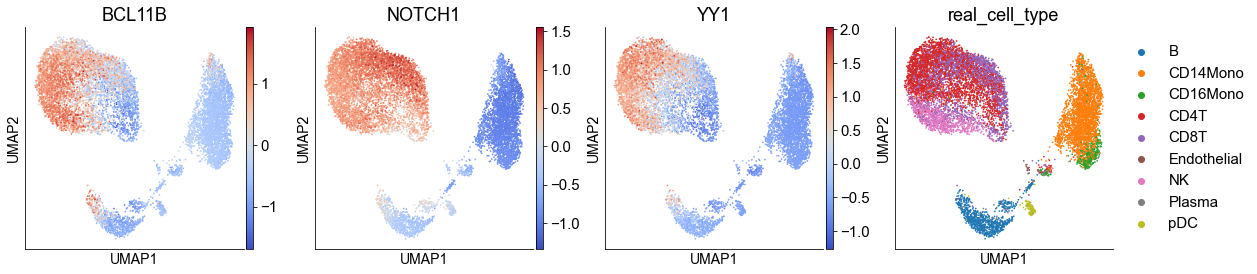

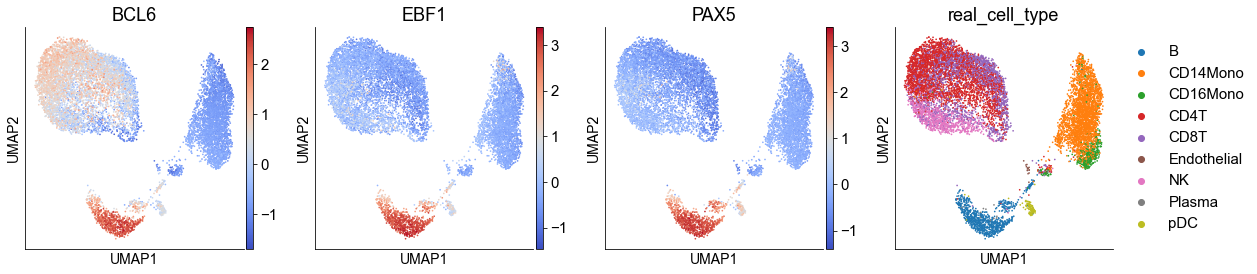

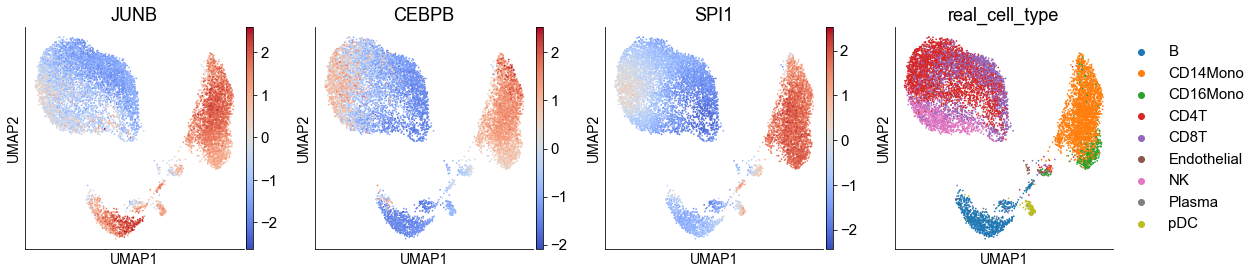

In [633]:
sc.pl.umap(max_adata, color=['BCL11B', 'NOTCH1', 'YY1', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(max_adata, color=['BCL6', 'EBF1', 'PAX5', 'real_cell_type'], cmap='coolwarm')
sc.pl.umap(max_adata, color=['JUNB', 'CEBPB', 'SPI1', 'real_cell_type'], cmap='coolwarm')

In [849]:
plt_data = pd.DataFrame(
    {'Matched Cell Type(340 TRs)': {'NMI':0.5897280482467733, 'ARI':0.4321359877972484},
     'Average(340 TRs)': {'NMI':0.5694341475826487, 'ARI':0.3888678260006303},
     'Maximum(340 TRs)': {'NMI':0.580413913986108, 'ARI':0.46213051982903147},
     'Average(All TRs)': {'NMI':0.5922649962908474, 'ARI':0.43675003358489983},
     'Maximum(All TRs)': {'NMI':0.6246759745391729, 'ARI':0.5282450451124835}
             }).T
plt_data = plt_data.melt()

In [850]:
plt_data['Method'] = ['Matched Cell Type(340 TRs)', 'Average(340 TRs)', 'Maximum(340 TRs)', 'Average(All TRs)','Maximum(All TRs)']*2

In [851]:
plt_data.columns = ['Evaluation', 'Value', 'Method']

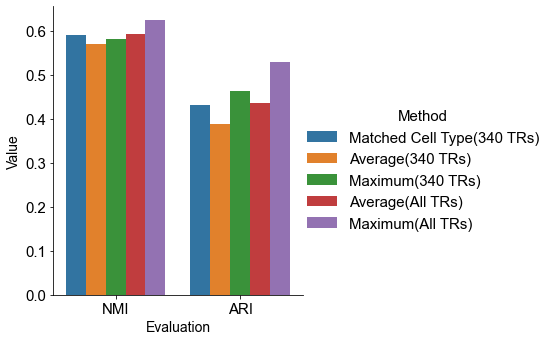

In [852]:
g = sns.catplot(data=plt_data, kind="bar", x="Evaluation", y="Value", hue="Method")
# g.set_xticklabels(rotation=30)

## data source

In [5]:
tmp=read_pickle('example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_score_source_df.pk')
score = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_overlap_df.pk')

In [22]:
not_only_motif_factor = []
for i in [i[0:-7] for i in os.listdir('/fs/home/dongxin/Projects/SCRIPT/indices/index/TR_mouse/raw_beds')]:
    x = 0
    if i.endswith('_motif'):
        factor =  i.split('_')[0]
        for j in [i[0:-7] for i in os.listdir('/fs/home/dongxin/Projects/SCRIPT/indices/index/TR_mouse/raw_beds')]:
            if j.split('_')[0] == factor and j!= f'{factor}_motif':
                x += 1
    if x >= 1:
        not_only_motif_factor.append(factor)

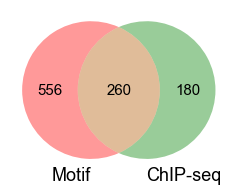

In [41]:
venn2_unweighted((816-260,440-260,260), ['Motif','ChIP-seq']) # mouse

In [30]:
not_only_motif_factor = []
for i in score.index:
    x = 0
    if i.endswith('_motif'):
        factor =  i.split('_')[0]
        for j in score.index:
            if j.split('_')[0] == factor and j!= f'{factor}_motif':
                x += 1
    if x >= 1:
        not_only_motif_factor.append(factor)

In [31]:
not_only_motif_factor.__len__()

335

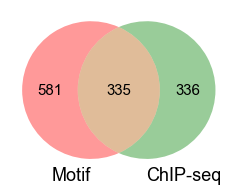

In [43]:
venn2_unweighted((916-335,671-335,335), ['Motif','ChIP-seq']) # human

In [860]:
statistic_dict = {}
for i in not_only_motif_factor:
    k = 0
    for j in tmp.loc[i,:]:
        if j.endswith('_motif'):
            k += 1
    statistic_dict[i] = {'motif_number': k}

In [ ]:
statistic_dict

In [862]:
motif_sample_statis = pd.DataFrame(statistic_dict).T/11180

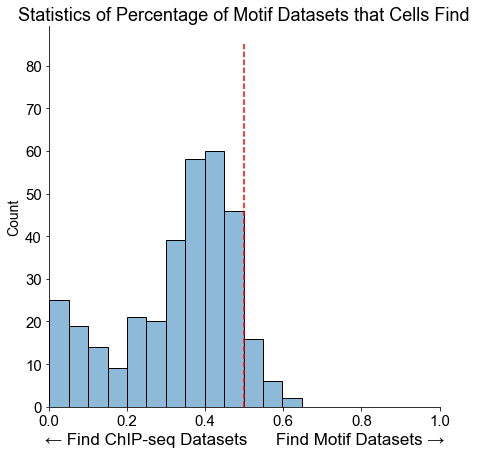

In [863]:
fig, ax = plt.subplots(figsize=(7,7))
sns.histplot(motif_sample_statis, legend=False, ax =ax)
ax.set_title('Statistics of Percentage of Motif Datasets that Cells Find')
ax.set_xlabel('← Find ChIP-seq Datasets      Find Motif Datasets →', size=17)
ax.set_xlim(0,1)
ax.vlines(0.5,0,85, color='red', linestyles='dashed')
fig.show()

## check BCL11A & BCL11B cell type

In [865]:
tmp = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_score_source_df.pk')

In [866]:
tmp.loc['BCL11A',:].value_counts()

BCL11A_motif    10616
Name: BCL11A, dtype: int64

In [867]:
tmp.loc['BCL11B',:].value_counts()

BCL11B_73985    5849
BCL11B_motif    3972
BCL11B_64464     795
Name: BCL11B, dtype: int64

In [868]:
BCL11B_73985_index = tmp.loc['BCL11B',:].index[tmp.loc['BCL11B',:] == 'BCL11B_73985']
BCL11B_64464_index = tmp.loc['BCL11B',:].index[tmp.loc['BCL11B',:] == 'BCL11B_64464']
BCL11B_motif_index = tmp.loc['BCL11B',:].index[tmp.loc['BCL11B',:] == 'BCL11B_motif']

In [869]:
BCL11B_73985_series = metadata.loc[BCL11B_73985_index,'Celltype'].value_counts()
BCL11B_64464_series = metadata.loc[BCL11B_64464_index,'Celltype'].value_counts()
BCL11B_motif_series = metadata.loc[BCL11B_motif_index,'Celltype'].value_counts()

In [870]:
plt_data = pd.DataFrame([BCL11B_73985_series,BCL11B_motif_series, BCL11B_64464_series], index=['BCL11B_73985', 'BCL11B_motif', 'BCL11B_64464']).T.sort_index().T
# plt_data.melt(ignore_index=False)

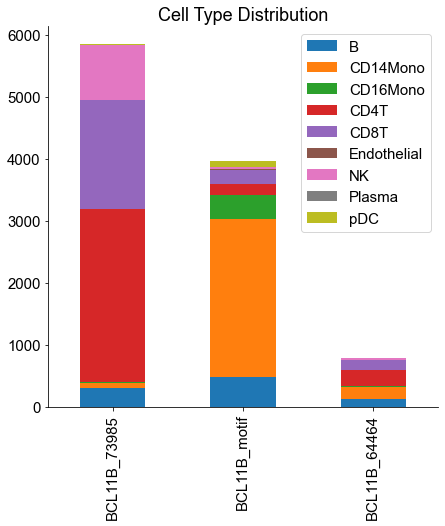

In [871]:
fig, ax = plt.subplots(figsize=[7,7])
plt_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Cell Type Distribution')
fig.show()

## RP evaluation

In [23]:
expression = rna_adata.to_df()

In [24]:
keys.index = keys['RNA']
expression.index = keys.loc[expression.index, 'ATAC']

In [25]:
tmp_rp = sc.read_h5ad('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/imputation/RP/BACH1_enhanced_auto.h5ad').to_df()

In [27]:
ovlp_gene_list = list(set(tmp_rp.columns).intersection(expression.columns))
ovlp_cell_list = list(set(tmp_rp.index).intersection(expression.index))
ovlp_gene_list.sort()

In [29]:
scrip_negative_TF = ['GLIS2', 'HES4', 'BCL6', 'OSR2', 'AR', 'HOXA6', 'EGR2', 'ZBTB7C', 'KLF4', 'KLF10']
chromvar_negative_TF = ['BCL11B', 'BACH2', 'TCF7L2', 'LMO2', 'MYCN', 'PROX1', 'NR1I2', 'EGR2', 'SNAI1', 'FOXO3']
scrip_positive_TF = ['JDP2', 'CREB5', 'FOSL1', 'BCL11A', 'SPI1', 'IRF8', 'EHF', 'EBF1','PAX5', 'GATA2']
chromvar_positive_TF = ['CREB5', 'BCL11A', 'GATA6', 'SPI1', 'RORC', 'PAX5', 'EOMES', 'EBF1', 'LEF1', 'GATA2']
negative_TF = scrip_negative_TF + chromvar_negative_TF
positive_TF = scrip_positive_TF + chromvar_positive_TF
scrip_TF = scrip_negative_TF + scrip_positive_TF
chromvar_TF = chromvar_negative_TF + chromvar_positive_TF
all_tf = list(set(negative_TF + positive_TF))

In [253]:
celltype_list = metadata['Celltype'].unique()
for celltype in celltype_list:
    print(celltype)
    locals()['%s_barcode' % celltype] = list(set(metadata[metadata['Celltype'] == celltype].index).intersection(tmp_rp.index).intersection(expression.index))

CD8T
CD14Mono
CD4T
CD16Mono
B
NK
Endothelial
pDC
Plasma


In [368]:
celltype_factor_list = []
for celltype in celltype_list:
    print(celltype)
    celltype_factor_list += script_result_table.loc[:,locals()['%s_barcode' % celltype]].mean(1).sort_values(ascending=False)[0:10].index.tolist()
celltype_factor_list = list(set(celltype_factor_list))

CD8T
CD14Mono
CD4T
CD16Mono
B
NK
Endothelial
pDC
Plasma


In [402]:
for i in set(celltype_factor_list).intersection(expression.columns):
    print(i,end=' ')
used_tf = set(celltype_factor_list).intersection(expression.columns)
few_target_tf = ['CD74', 'FOXP1', 'CDK2', 'CUX1', 'NCOR2', 'FOXO1', 'STAG1', 'NCOR1', 'NR4A2','JARID2','CDK12','FUS']
tf_1k = ["MYB", "GATA3", "ESCO2", "TCF4", "POU2F1", "MEF2B", "CEBPA", "SMC3", "IRF5", "LDB1", "ELF4", "RAG2", "RAD21", "EHF", "TERF2", "HMG20A", "LMO1", "GATA2",
        'TCF7L1', 'EED', 'PAX5', 'CEBPG', 'FIGLA', 'STAT5A', 'EBF1', 'KDM3B', 'TBX18', 'SKI', 'TERF1', 'ASH2L','ZBED1', 'TCF3','ASCL2','ICE1','GTF3C5','TAL2', 'RUNX3','CBX3','FOXP3','HES2','PSIP1','TBX21','PLAGL2']
tf_10k =  ["TBX20", "GRIP1", "TBX6", "ZNF654", "CEBPE", "LYL1", "MSC", 'DBP', 'IRF8', 'NR4A3', 'NFE2L1','ZNF223','RARB']

MYB STAG1 GATA3 TCF7L1 EED PAX5 DBP IRF8 TBX20 ESCO2 NCOR1 CEBPG TCF4 FIGLA STAT5A NR4A3 POU2F1 EBF1 MEF2B GRIP1 ZBED1 CEBPA SMC3 IRF5 KDM3B FOXO1 NR4A2 TBX18 SKI NFE2L1 TERF1 ASH2L LDB1 TBX6 FOXP1 TCF3 CD74 ASCL2 ZNF654 ICE1 GTF3C5 JARID2 CUX1 CDK12 ZNF223 NCOR2 CEBPE LYL1 TAL2 RUNX3 CBX3 MSC FUS FOXP3 HES2 ELF4 PSIP1 RAG2 TBX21 RARB RAD21 EHF TERF2 HMG20A LMO1 PLAGL2 GATA2 

In [ ]:
for i in set(celltype_factor_list).intersection(expression.columns) - set(tf_1k + tf_10k):
    print(i)
    enhanced_total_1k = bar_plot_df[(bar_plot_df['TF'] == i) & (bar_plot_df['Decay'] == '1000') & (bar_plot_df['Model'] == 'enhanced') & (bar_plot_df['Direction'] == 'total')]['Count'].values[0]
    enhanced_total_10k = bar_plot_df[(bar_plot_df['TF'] == i) & (bar_plot_df['Decay'] == '10000') & (bar_plot_df['Model'] == 'enhanced') & (bar_plot_df['Direction'] == 'total')]['Count'].values[0]
    enhanced_total_auto = bar_plot_df[(bar_plot_df['TF'] == i) & (bar_plot_df['Decay'] == 'auto') & (bar_plot_df['Model'] == 'enhanced') & (bar_plot_df['Direction'] == 'total')]['Count'].values[0]
    if enhanced_total_1k <100:
        print('useless')
    else:
        if enhanced_total_1k == enhanced_total_auto:
            print('1k')
        if enhanced_total_10k == enhanced_total_auto:
            print('10k')
    print('====')

In [ ]:
for celltype in celltype_list:
    locals()['%s_expr' % celltype] = expression.loc[locals()['%s_barcode' % celltype],:]

In [813]:
directory = '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/imputation/RP/'
file_list = os.listdir(directory)
file_list.sort()

In [ ]:
No = 0
df_dict = {}
print(file_list.__len__())
for file in file_list:
    tf = file.split('_')[0]
    model = file.split('_')[1]
    decay = file.split('_')[2][0:-5]
#     if tf in set(celltype_factor_list).intersection(expression.columns):
    if tf in expression.columns:        
        tmp_rp = sc.read_h5ad(os.path.join(directory, file)).to_df()
        tmp_rp = tmp_rp.loc[:, ovlp_gene_list].copy()
        target_list = []
        for celltype in celltype_list:
            target_list += tmp_rp.loc[locals()['%s_barcode' % celltype],:].mean().sort_values(ascending=False).index[0:200].tolist()
        target_list = list(set(target_list).intersection(expression.columns))
        for target in target_list:
            Scorrelation = scipy.stats.spearmanr(expression[tf],expression[target])
            ScorrR = Scorrelation[0]
            ScorrP = Scorrelation[1]
            Pcorrelation = scipy.stats.pearsonr(expression[tf],expression[target])
            PcorrR = Pcorrelation[0]
            PcorrP = Pcorrelation[1]
            auc = metrics.roc_auc_score([1 if i > 0  else 0 for i in expression[tf]], expression[target])
            df_dict[No] = {'Spearman Correlation': ScorrR, 
                           'Spearman Correlation P value': ScorrP, 
                           'Pearson Correlation': PcorrR, 
                           'Pearson Correlation P value': PcorrP, 
                           'AUC': auc,
                           'TF':tf , 
                           'Target':target , 
                           'Model':model , 
                           'Decay':decay}
            No += 1
            if No % 20 == 0:
                print(df_dict[No-1])
                print(df_dict.__len__())                

In [835]:
model_data_df = pd.DataFrame(df_dict).T

In [837]:
bar_plot_dict = {}
cut = 0.3
n=0
for d in model_data_df["Decay"].unique():
    for m in model_data_df["Model"].unique():
        for tf in model_data_df["TF"].unique():
            nc = len(model_data_df[(model_data_df["TF"] == tf) & (model_data_df["Decay"] == d) & (model_data_df["Model"] == m) & (model_data_df["Spearman Correlation P value"] < 0.01) & (model_data_df["Spearman Correlation"] < -cut)])
            pc = len(model_data_df[(model_data_df["TF"] == tf) & (model_data_df["Decay"] == d) & (model_data_df["Model"] == m) & (model_data_df["Spearman Correlation P value"] < 0.01) & (model_data_df["Spearman Correlation"] > cut)])
            c = len(model_data_df[(model_data_df["TF"] == tf) & (model_data_df["Decay"] == d) & (model_data_df["Model"] == m) & (model_data_df["Spearman Correlation P value"] < 0.01) & (abs(model_data_df["Spearman Correlation"]) > cut)])
            bar_plot_dict[n] = {'Count':nc, 'Decay':d, 'Model':m, 'Direction': 'negative', 'TF':tf}
            bar_plot_dict[n+1] = {'Count':pc, 'Decay':d, 'Model':m, 'Direction': 'positive', 'TF':tf}
            bar_plot_dict[n+2] = {'Count':c, 'Decay':d, 'Model':m, 'Direction': 'total', 'TF':tf}
            n+=3
bar_plot_df = pd.DataFrame(bar_plot_dict).T

In [ ]:
bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k))].sort_values(by='Count').tail(60)

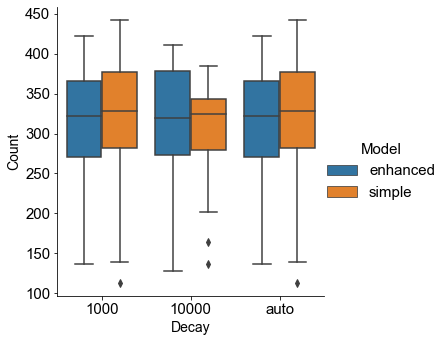

In [397]:
sns.catplot(data=bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_1k))], kind='box', x='Decay', y='Count', hue='Model')

In [ ]:
bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k + tf_1k))].sort_values('Count').head(60)

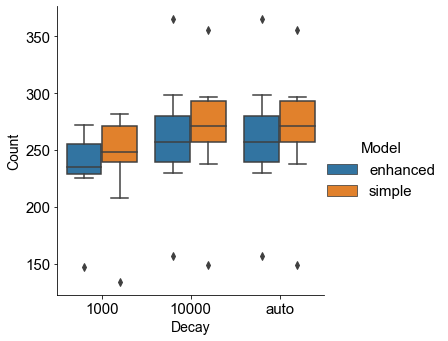

In [398]:
sns.catplot(data=bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k))], kind='box', x='Decay', y='Count', hue='Model')

In [ ]:
for i in tf_10k + tf_1k:
    print(bar_plot_df[(bar_plot_df['Direction']=='total')& (bar_plot_df['TF'] == i)].sort_values(by='Count').head(30))

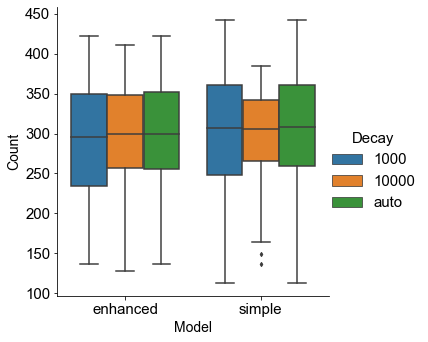

In [894]:
sns.catplot(data=bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k+tf_1k))], kind='box', x='Model', y='Count', hue='Decay', fliersize=3)

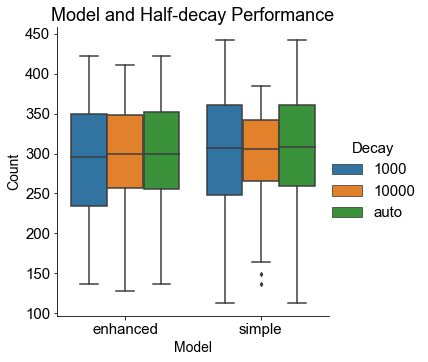

In [895]:
sns.catplot(data=bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_1k + tf_10k))], kind='box', x='Model', y='Count', hue='Decay',fliersize=3).set(title = 'Model and Half-decay Performance').savefig('Figures/Model_and_Decay_Performance.pdf')

In [507]:
a = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='simple') & (bar_plot_df['TF'].isin(tf_1k + tf_10k)) & (bar_plot_df['Decay'] == 'auto')]['Count'].values.tolist()
b = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='enhanced') & (bar_plot_df['TF'].isin(tf_1k + tf_10k)) & (bar_plot_df['Decay'] == '10000')]['Count'].values.tolist()
c = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='enhanced') & (bar_plot_df['TF'].isin(tf_1k + tf_10k)) & (bar_plot_df['Decay'] == 'auto')]['Count'].values.tolist()

In [508]:
scipy.stats.mannwhitneyu(a,c)

MannwhitneyuResult(statistic=1690.0, pvalue=0.47952723664586294)

In [511]:
a = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='simple') & (bar_plot_df['TF'].isin(tf_10k)) & (bar_plot_df['Decay'] == '1000')]['Count'].values.tolist()
b = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='simple') & (bar_plot_df['TF'].isin(tf_10k)) & (bar_plot_df['Decay'] == '10000')]['Count'].values.tolist()
# c = bar_plot_df[(bar_plot_df['Direction']=='total') & (bar_plot_df['Model']=='enhanced') & (bar_plot_df['TF'].isin(tf_1k)) & (bar_plot_df['Decay'] == 'auto')]['Count'].values.tolist()
scipy.stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=47.0, pvalue=0.05764213405387302)

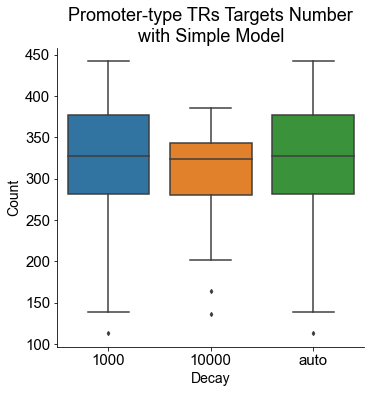

In [770]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
sns.boxplot(data=bar_plot_df[(bar_plot_df['Model']=='simple') & (bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_1k))], x='Decay', y='Count', fliersize=3)
ax.set(title = 'Promoter-type TRs Targets Number\nwith Simple Model')
fig.savefig('Figures/Promoter_TRs_simple.pdf')

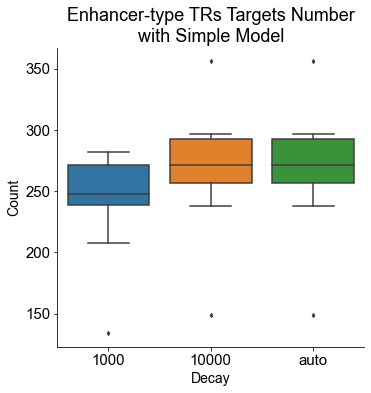

In [771]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
sns.boxplot(data=bar_plot_df[(bar_plot_df['Model']=='simple') & (bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k))], x='Decay', y='Count', fliersize=3)
ax.set(title = 'Enhancer-type TRs Targets Number\nwith Simple Model')
fig.savefig('Figures/enhancer_TRs_simple.pdf')

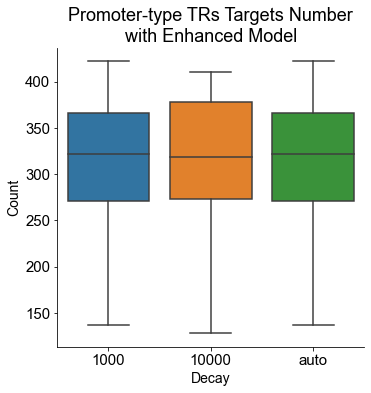

In [772]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
sns.boxplot(data=bar_plot_df[(bar_plot_df['Model']=='enhanced') & (bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_1k))], x='Decay', y='Count', fliersize=3)
ax.set(title = 'Promoter-type TRs Targets Number\nwith Enhanced Model')
fig.savefig('Figures/Promoter_TRs_enhanced.pdf')

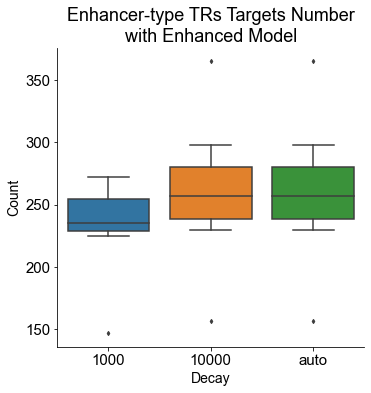

In [773]:
fig, ax = plt.subplots(figsize=(5.5,5.5))
sns.boxplot(data=bar_plot_df[(bar_plot_df['Model']=='enhanced') & (bar_plot_df['Direction']=='total') & (bar_plot_df['TF'].isin(tf_10k))], x='Decay', y='Count', fliersize=3)
ax.set(title = 'Enhancer-type TRs Targets Number\nwith Enhanced Model')
fig.savefig('Figures/enhancer_TRs_enhanced.pdf')

[Text(0.5, 1.0, 'IRF8 Targets Number')]

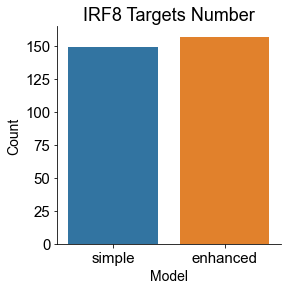

In [669]:
sns.barplot(data=bar_plot_df[(bar_plot_df['TF']=='IRF8') & (bar_plot_df['Decay']=='auto') & (bar_plot_df['Direction']=='total')], x='Model', y='Count', order=['simple', 'enhanced']).set(title = 'IRF8 Targets Number')

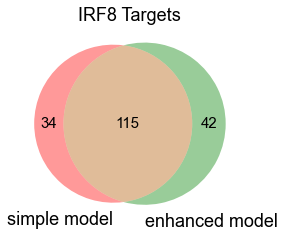

In [541]:
set1 = set(model_data_df[(model_data_df['TF'] == 'IRF8') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='simple') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())
set2 = set(model_data_df[(model_data_df['TF'] == 'IRF8') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='enhanced') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())

venn2([set1, set2], ('simple model', 'enhanced model'))
plt.title('IRF8 Targets')
plt.show()

[Text(0.5, 1.0, 'EBF1 Targets Number')]

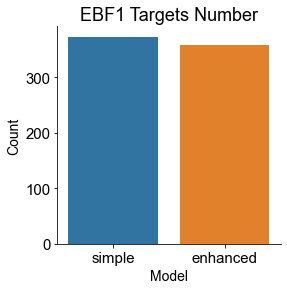

In [668]:
sns.barplot(data=bar_plot_df[(bar_plot_df['TF']=='EBF1') & (bar_plot_df['Decay']=='auto') & (bar_plot_df['Direction']=='total')], x='Model', y='Count', order=['simple', 'enhanced']).set(title = 'EBF1 Targets Number')

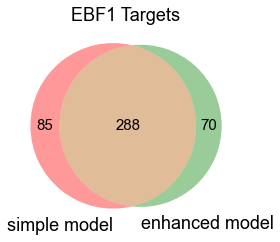

In [543]:
set1 = set(model_data_df[(model_data_df['TF'] == 'EBF1') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='simple') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())
set2 = set(model_data_df[(model_data_df['TF'] == 'EBF1') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='enhanced') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())

venn2([set1, set2], ('simple model', 'enhanced model'))
plt.title('EBF1 Targets')
plt.show()

[Text(0.5, 1.0, 'TBX20 Targets Number')]

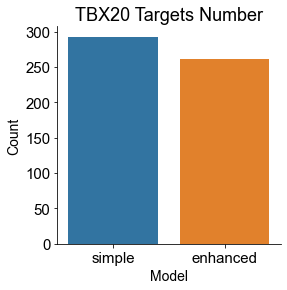

In [667]:
sns.barplot(data=bar_plot_df[(bar_plot_df['TF']=='TBX20') & (bar_plot_df['Decay']=='auto') & (bar_plot_df['Direction']=='total')], x='Model', y='Count', order=['simple', 'enhanced']).set(title = 'TBX20 Targets Number')

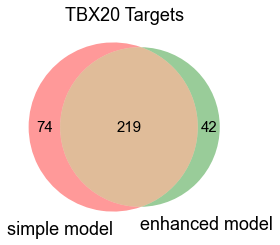

In [654]:
set1 = set(model_data_df[(model_data_df['TF'] == 'TBX20') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='simple') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())
set2 = set(model_data_df[(model_data_df['TF'] == 'TBX20') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='enhanced') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())

venn2([set1, set2], ('simple model', 'enhanced model'))
plt.title('TBX20 Targets')
plt.show()

[Text(0.5, 1.0, 'CEBPA Targets Number')]

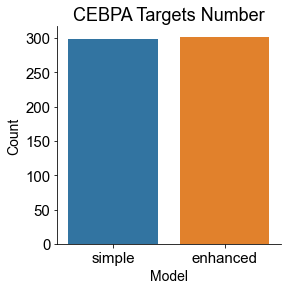

In [671]:
sns.barplot(data=bar_plot_df[(bar_plot_df['TF']=='CEBPA') & (bar_plot_df['Decay']=='auto') & (bar_plot_df['Direction']=='total')], x='Model', y='Count', order=['simple', 'enhanced']).set(title = 'CEBPA Targets Number')

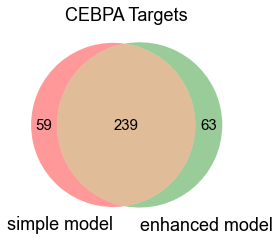

In [672]:
set1 = set(model_data_df[(model_data_df['TF'] == 'CEBPA') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='simple') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())
set2 = set(model_data_df[(model_data_df['TF'] == 'CEBPA') & (model_data_df['Decay']=='auto') & (model_data_df['Model']=='enhanced') & (abs(model_data_df['Spearman Correlation']) > 0.3) & (model_data_df["Spearman Correlation P value"] < 0.01)]['Target'].values.tolist())

venn2([set1, set2], ('simple model', 'enhanced model'))
plt.title('CEBPA Targets')
plt.show()

## normalization distribution

In [6]:
dataset_overlap_df = read_pickle('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/dataset_overlap_df.pk')

In [196]:
index_ovlp = set(metadata.index).intersection(dataset_overlap_df.columns)
# factor_list = ['BCL11A','BCL11B', 'CEBPA', 'CEBPB','GATA1', 'GATA2', 'GATA3', 'GATA6','GRIP1', 'NRF1', 'YY1','ARID1A','POLR2A','FOXO3','RXRG','EGLN2','NR4A1']
dataset_list = ['CEBPB_46206', 'GATA1_33543', 'GATA2_46032', 'GATA3_33679', 'NRF1_45624', 'POLR2A_73734', 'RXRG_motif', 'NR4A1_motif']
factor_list = ['CEBPB','GATA1', 'GATA2', 'GATA3', 'NRF1', 'POLR2A','RXRG','NR4A1']
cell_list = ['GAACTTAAGATTCGTT', 'TATCCGGGTGGGTAAC','GTATTGTTCCCGGAAA','AAGAATCGTAAACCGA' ]

In [38]:
peaks_number_path = '/fs/home/dongxin/Projects/SCRIPT/indices/index/TR_human/peaks_number.txt'
peaks_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)

In [9]:
# peaks_number_path = '/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIPT_20211011/all.result.txt'
# peaks_number = pd.read_csv(peaks_number_path, sep='\t', comment='#', header=None, index_col=0)
# peaks_number.index = [i[:-7] for i in peaks_number.index]
# peaks_number = peaks_number

In [71]:
qpeak_length = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/PBMC/multiome_pbmc_SCRIP_20220522/enrichment/qpeaks_length.txt', index_col=0, header=None, sep='\t')/1e8

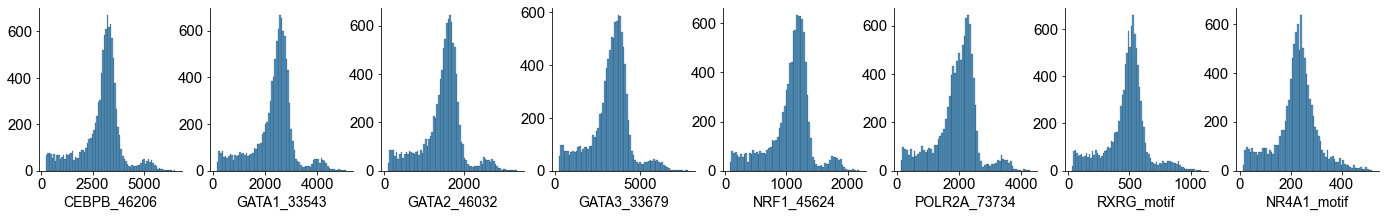

In [197]:
plot_tf_distribution(dataset_overlap_df, dataset_list, 'Figures/dataset_overlap_df.png')

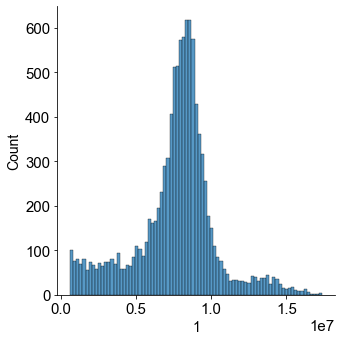

In [60]:
# qpeak_length = (qpeak_length/qpeak_length[1].max())
sns.displot(qpeak_length[1])

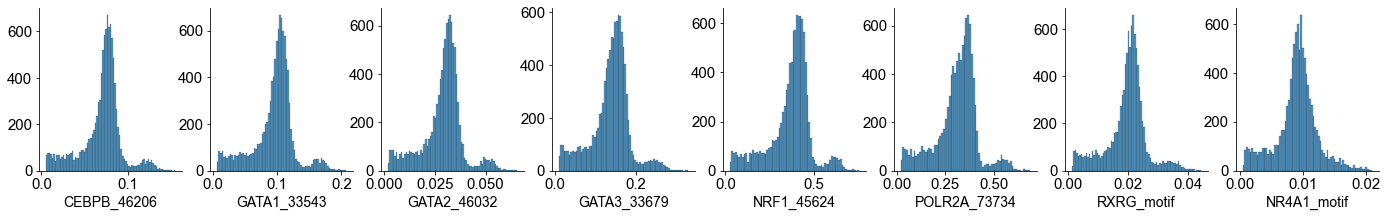

In [198]:
dataset_cell_percent = (dataset_overlap_df.T/peaks_number.loc[dataset_overlap_df.index, 1]).T
plot_tf_distribution(dataset_cell_percent, dataset_list, 'Figures/dataset_cell_percent.png')

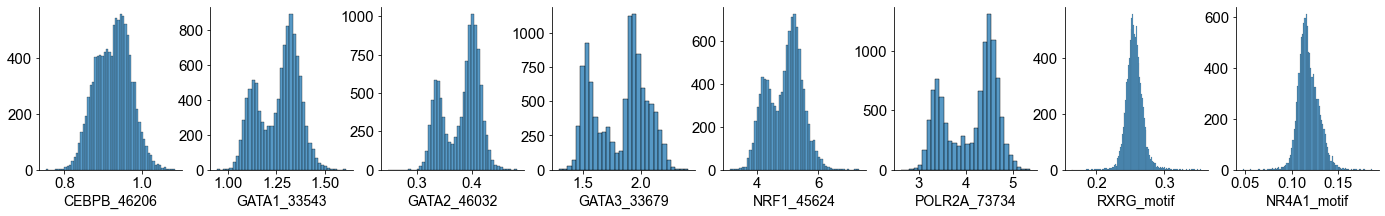

In [199]:
dataset_cell_percent_dl = dataset_cell_percent/qpeak_length.loc[dataset_cell_percent.columns, 1]
plot_tf_distribution(dataset_cell_percent_dl, dataset_list, 'Figures/dataset_cell_percent_dl.png')

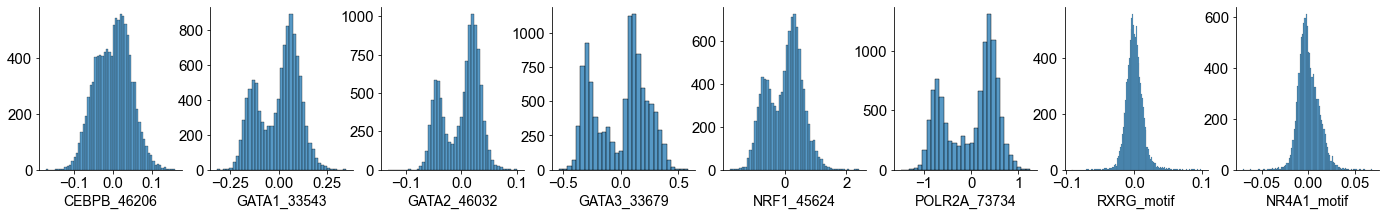

In [200]:
dataset_cell_percent_dl_dm = (dataset_cell_percent_dl.T - dataset_cell_percent_dl.mean(1)).T
plot_tf_distribution(dataset_cell_percent_dl_dm, dataset_list, 'Figures/dataset_cell_percent_dl_dm.png')

INFO 2022-06-16 15:43:51 Summary result from dataset level to factor level.


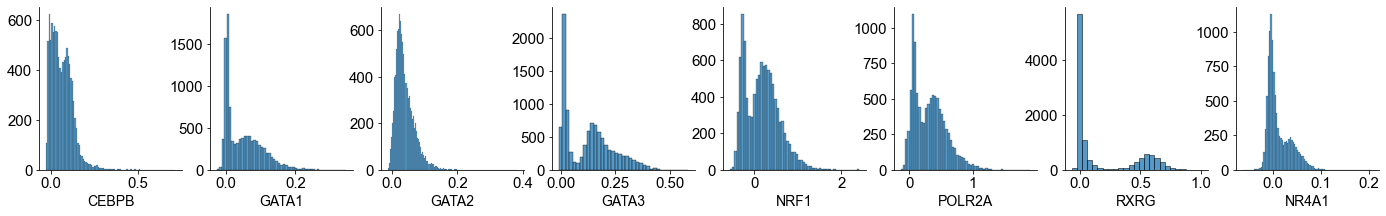

In [201]:
tf_cell_df = map_factor_on_ChIP(dataset_cell_percent_dl_dm)
plot_tf_distribution(tf_cell_df, factor_list, 'Figures/tf_cell_df.png')

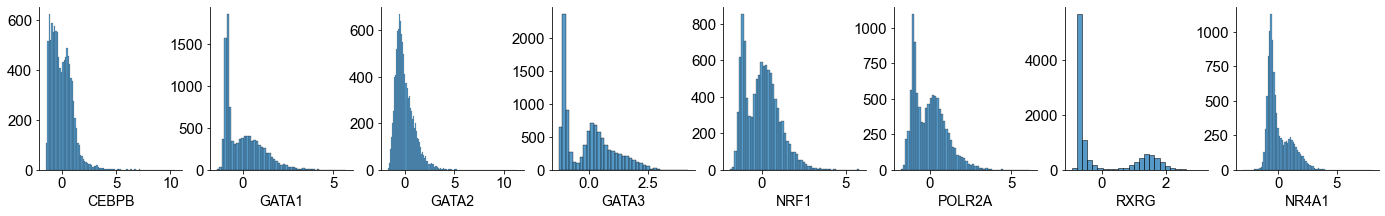

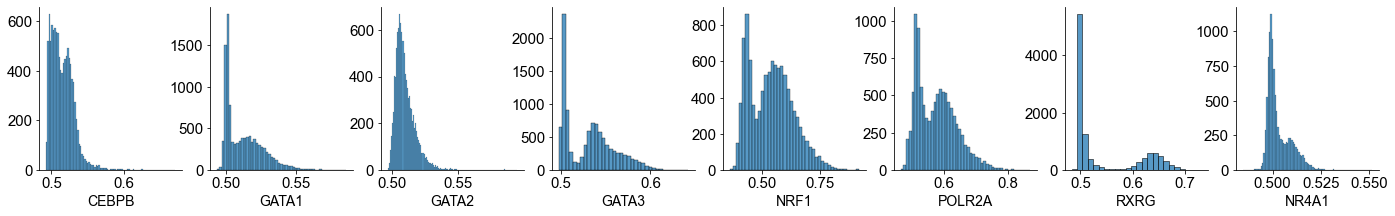

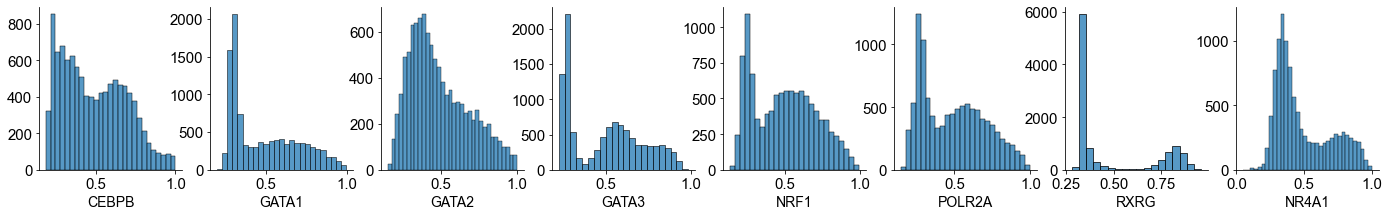

In [202]:
tmp = standardScaler(tf_cell_df.T).T
plot_tf_distribution(tmp, factor_list, 'Figures/tf_cell_df_std.png')
tf_cell_df_lsn = 1/(1+np.exp(-tf_cell_df))  # LSN(Logistic Sigmoid Normalisation)
plot_tf_distribution(tf_cell_df_lsn, factor_list, 'Figures/tf_cell_df_lsn.png')
tf_cell_df_lsn = 1/(1+np.exp(-tmp))  # LSN(Logistic Sigmoid Normalisation)
plot_tf_distribution(tf_cell_df_lsn, factor_list, 'Figures/tf_cell_df_std_lsn.png')

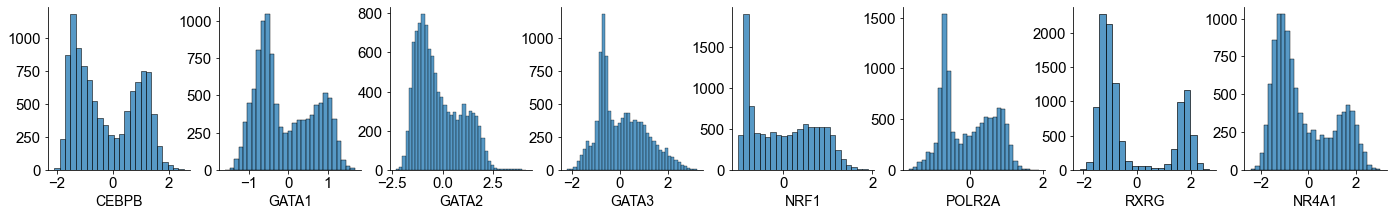

In [203]:
tf_cell_df_lsn_std = standardScaler(tf_cell_df_lsn)
plot_tf_distribution(tf_cell_df_lsn_std, factor_list, 'Figures/tf_cell_df_std_lsn_std.png')

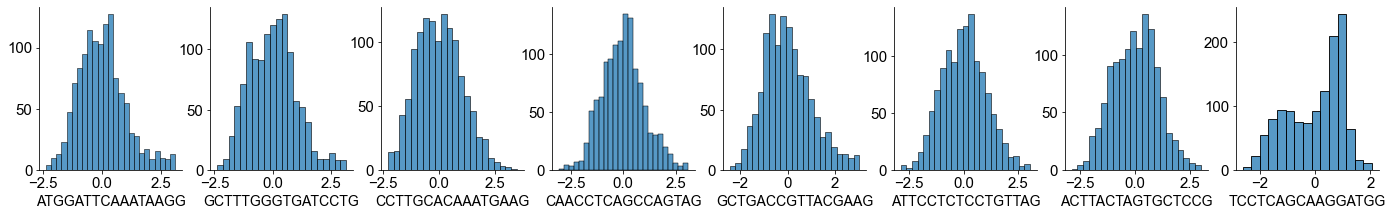

In [205]:
cell_list = ['ATGGATTCAAATAAGG', 'GCTTTGGGTGATCCTG','CCTTGCACAAATGAAG','CAACCTCAGCCAGTAG','GCTGACCGTTACGAAG', 'ATTCCTCTCCTGTTAG', 'ACTTACTAGTGCTCCG', 'TCCTCAGCAAGGATGG']
plot_tf_distribution(tf_cell_df_lsn_std, cell_list, 'Figures/tf_cell_df_std_lsn_std_cell.png')